# Capstone project - OO - API 4QR Data

In [1]:
#Import key libraries for analysis and array
import requests
import pandas as pd
import numpy as np
import random

#imaging and redering
from IPython.display import Image 
from IPython.core.display import HTML 

from pandas.io.json import json_normalize # to convert json to dataframe

!conda install -c conda-forge geopy --yes #to obtain coordinates
from geopy.geocoders import Nominatim

!conda install -c conda-forge folium=0.5.0 --yes #for maps
import folium

print('Folium installed')
print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Folium installed
Libraries imported.


In [2]:
! pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import matplotlib.pylab as plt

from PIL import Image
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

%matplotlib inline 

### Search and Map Recycling Facilities in Lagos

In [3]:
# API call credentials 
CLIENT_ID = 'ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ'
CLIENT_SECRET = 'I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN'
VERSION = '20180604'
LIMIT = 100
print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ
CLIENT_SECRET:I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN


In [4]:
# Search parameters 
search_query = ''
categoryId = ['4f4531084b9074f6e4fb0101', '58daa1558bbb0b01f18ec1ac'] # foursquare category id for recycling facilities
radius = 30000
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [5]:
#search coordinates of a roughly central location in Lagos
address = "Lagos Polytechnic Isolo, Lagos, Nigeria"

geolocator = Nominatim(user_agent="foursquare_agent")
locationla = geolocator.geocode(address)
latitudela = locationla.latitude
longitudela = locationla.longitude
print(latitudela, longitudela)

6.53001215 3.333809764672579


In [6]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={},{}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudela, longitudela, VERSION, search_query, categoryId[0], categoryId[1], radius, intent, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=6.53001215,3.333809764672579&v=20180604&query=&categoryId=4f4531084b9074f6e4fb0101,58daa1558bbb0b01f18ec1ac&radius=30000&intent=&limit=100'

In [7]:
results = requests.get(url).json() #raw search results
results

{'meta': {'code': 200, 'requestId': '5f917a26afd98854ddfaccda'},
 'response': {'venues': [{'id': '4f7c901be4b02e0090c860cf',
    'name': 'SUNGAS PLC., Off Oba Akran Avenue, Ikeja.',
    'location': {'lat': 6.601615536887937,
     'lng': 3.344364514595412,
     'labeledLatLngs': [{'label': 'display',
       'lat': 6.601615536887937,
       'lng': 3.344364514595412}],
     'distance': 8055,
     'cc': 'NG',
     'city': 'Lagos',
     'state': 'Lagos',
     'country': 'Nigeria',
     'formattedAddress': ['Lagos', 'Lagos', 'Nigeria']},
    'categories': [{'id': '4f4531084b9074f6e4fb0101',
      'name': 'Recycling Facility',
      'pluralName': 'Recycling Facilities',
      'shortName': 'Recycling',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/recycling_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1603369510',
    'hasPerk': False},
   {'id': '4f7be31de4b0222829e2432c',
    'name': 'Lawma Dump',
    'location': {'lat': 6.45840231407270

In [8]:
lagrec_data = results['response']['venues'] #refined search data

In [9]:
lagrec_data[0] #check the first row of data for pattern

{'id': '4f7c901be4b02e0090c860cf',
 'name': 'SUNGAS PLC., Off Oba Akran Avenue, Ikeja.',
 'location': {'lat': 6.601615536887937,
  'lng': 3.344364514595412,
  'labeledLatLngs': [{'label': 'display',
    'lat': 6.601615536887937,
    'lng': 3.344364514595412}],
  'distance': 8055,
  'cc': 'NG',
  'city': 'Lagos',
  'state': 'Lagos',
  'country': 'Nigeria',
  'formattedAddress': ['Lagos', 'Lagos', 'Nigeria']},
 'categories': [{'id': '4f4531084b9074f6e4fb0101',
   'name': 'Recycling Facility',
   'pluralName': 'Recycling Facilities',
   'shortName': 'Recycling',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/recycling_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369510',
 'hasPerk': False}

In [10]:
# define the dataframe columns
column_names = ['Name', 'Latitude', 'Longitude', 'Category'] 

# instantiate empty dataframe for refined data
df_lagrec = pd.DataFrame(columns=column_names)
df_lagrec

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [11]:
#Loop to fill the dataframe
for data in lagrec_data:
    venue_name = data['name']
    venue_lat = data['location']['lat']
    venue_lng = data['location']['lng']
    
    venue_cat = data['categories']
    venue_catt = venue_cat[0]['name']
    
    df_lagrec = df_lagrec.append({'Name': venue_name, 'Latitude': venue_lat, 'Longitude': venue_lng, 'Category': venue_catt}, ignore_index=True)

In [12]:
df_lagrec.head() #check table is ok

Name  Latitude  Longitude  \
0  SUNGAS PLC., Off Oba Akran Avenue, Ikeja.  6.601616   3.344365   
1                                 Lawma Dump  6.458402   3.400722   

             Category  
0  Recycling Facility  
1  Recycling Facility

In [13]:
#Get geocode coordinates for entire Lagos

address = 'Lagos, Nigeria'

geolocator = Nominatim(user_agent="foursquare_agent")
locationlagt = geolocator.geocode(address)
latitudelagt = locationlagt.latitude
longitudelagt = locationlagt.longitude
print('The coordinates of Lagos are {}, {}.'.format(latitudelagt, longitudelagt))

The coordinates of Lagos are 6.4550575, 3.3941795.


In [14]:
# Wider/Total Lagos map
map_lagos = folium.Map(location=[latitudelagt, longitudelagt], zoom_start=10)

# add markers of recycling facilities to map
for name, lat, lng, category in zip(df_lagrec['Name'], df_lagrec['Latitude'], df_lagrec['Longitude'], df_lagrec['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lagos)  
    
map_lagos

### Search and Map Supermarkets in Lagos

In [15]:
#search parameters for Supermarkets around central London
search_query = ''
categoryId = '52f2ab2ebcbc57f1066b8b46'
radius = 30000
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [16]:
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudela, longitudela, VERSION, search_query, categoryId, radius, intent, LIMIT)
url2

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=6.53001215,3.333809764672579&v=20180604&query=&categoryId=52f2ab2ebcbc57f1066b8b46&radius=30000&intent=&limit=100'

In [17]:
results2 = requests.get(url2).json()
results2

{'meta': {'code': 200, 'requestId': '5f917a272be1a37c28f62b2b'},
 'response': {'venues': [{'id': '587d114de612f226c8c2be4d',
    'name': 'Taiwo Supermarket',
    'location': {'address': 'Ire Akari Road',
     'lat': 6.527241,
     'lng': 3.322199,
     'labeledLatLngs': [{'label': 'display',
       'lat': 6.527241,
       'lng': 3.322199}],
     'distance': 1320,
     'cc': 'NG',
     'city': 'Lagos',
     'state': 'Lagos',
     'country': 'Nigeria',
     'formattedAddress': ['Ire Akari Road', 'Lagos', 'Lagos', 'Nigeria']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
      'name': 'Supermarket',
      'pluralName': 'Supermarkets',
      'shortName': 'Supermarket',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1603369511',
    'hasPerk': False},
   {'id': '5048bffae4b09eed3bad2446',
    'name': 'Prince Ebeano supermarket (new)',
    'location': {'address': 'Admiralt

In [18]:
lagspm_data = results2['response']['venues']

In [19]:
lagspm_data[0] #check the first row of data for pattern

{'id': '587d114de612f226c8c2be4d',
 'name': 'Taiwo Supermarket',
 'location': {'address': 'Ire Akari Road',
  'lat': 6.527241,
  'lng': 3.322199,
  'labeledLatLngs': [{'label': 'display', 'lat': 6.527241, 'lng': 3.322199}],
  'distance': 1320,
  'cc': 'NG',
  'city': 'Lagos',
  'state': 'Lagos',
  'country': 'Nigeria',
  'formattedAddress': ['Ire Akari Road', 'Lagos', 'Lagos', 'Nigeria']},
 'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
   'name': 'Supermarket',
   'pluralName': 'Supermarkets',
   'shortName': 'Supermarket',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369511',
 'hasPerk': False}

In [20]:
# define the dataframe columns
column_names2 = ['Name', 'Latitude', 'Longitude', 'Category'] 

# instantiate the dataframe
df_lagspm = pd.DataFrame(columns=column_names2)
df_lagspm

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [21]:
#Loop to fill new dataframe
for data2 in lagspm_data:
    venue_name2 = data2['name']
    venue_lat2 = data2['location']['lat']
    venue_lng2 = data2['location']['lng']
    
    venue_cat2 = data2['categories']
    venue_catt2 = venue_cat2[0]['name']
    
    df_lagspm = df_lagspm.append({'Name': venue_name2, 'Latitude': venue_lat2, 'Longitude': venue_lng2, 'Category': venue_catt2}, ignore_index=True)

In [22]:
df_lagspm.head() #check table is ok

Name  Latitude  Longitude     Category
0                Taiwo Supermarket  6.527241   3.322199  Supermarket
1  Prince Ebeano supermarket (new)  6.447415   3.470509  Supermarket
2        Prince Ebeano Supermarket  6.577115   3.360749  Supermarket
3                             Spar  6.429929   3.420672  Supermarket
4                             SPAR  6.590791   3.359802  Supermarket

In [23]:
df_lagspm.shape # check shape

(24, 4)

In [24]:
#Lagos map showing both Recycling Facilities and Supermarkets
map_lagos = folium.Map(location=[latitudelagt, longitudelagt], zoom_start=10)

# add markers of recycling facilities to map
for name, lat, lng, category in zip(df_lagrec['Name'], df_lagrec['Latitude'], df_lagrec['Longitude'], df_lagrec['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lagos)  
    

# add markers of super market facilities to map
for name, lat, lng, category in zip(df_lagspm['Name'], df_lagspm['Latitude'], df_lagspm['Longitude'], df_lagspm['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lagos)  
    
    
map_lagos

### Search Industrial Estates & Factories in Lagos

In [25]:
#search parameters for industrial within a small radius of central London 
search_query = ''
categoryId = ['56aa371be4b08b9a8d5734d7','4eb1bea83b7b6f98df247e06'] # category id for Industrial Estates & factories
radius = 30000
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [26]:
url2b = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={},{}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudela, longitudela, VERSION, search_query, categoryId[0], categoryId[1], radius, intent, LIMIT)
url2b

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=6.53001215,3.333809764672579&v=20180604&query=&categoryId=56aa371be4b08b9a8d5734d7,4eb1bea83b7b6f98df247e06&radius=30000&intent=&limit=100'

In [27]:
results2b = requests.get(url2b).json()
results2b

{'meta': {'code': 200, 'requestId': '5f917a294e36ac59a5db7252'},
 'response': {'venues': [{'id': '4f2bba6ee4b0ecad923662f8',
    'name': 'Expression Ltd',
    'location': {'address': 'Mojisola',
     'lat': 6.633517,
     'lng': 3.323558,
     'labeledLatLngs': [{'label': 'display',
       'lat': 6.633517,
       'lng': 3.323558}],
     'distance': 11577,
     'cc': 'NG',
     'country': 'Nigeria',
     'formattedAddress': ['Mojisola', 'Nigeria']},
    'categories': [{'id': '4eb1bea83b7b6f98df247e06',
      'name': 'Factory',
      'pluralName': 'Factories',
      'shortName': 'Factory',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/factory_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1603369513',
    'hasPerk': False},
   {'id': '562a565e498e4a8a9d40deb0',
    'name': 'Chris Coneb Co.,Ltd.',
    'location': {'address': '12 Balogun Street, Ago Palace Way',
     'crossStreet': 'Okota',
     'lat': 6.502233505249023,
     'lng': 3

In [28]:
lagind_data = results2b['response']['venues'] # create refined data and check
lagind_data[0]

{'id': '4f2bba6ee4b0ecad923662f8',
 'name': 'Expression Ltd',
 'location': {'address': 'Mojisola',
  'lat': 6.633517,
  'lng': 3.323558,
  'labeledLatLngs': [{'label': 'display', 'lat': 6.633517, 'lng': 3.323558}],
  'distance': 11577,
  'cc': 'NG',
  'country': 'Nigeria',
  'formattedAddress': ['Mojisola', 'Nigeria']},
 'categories': [{'id': '4eb1bea83b7b6f98df247e06',
   'name': 'Factory',
   'pluralName': 'Factories',
   'shortName': 'Factory',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/factory_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369513',
 'hasPerk': False}

In [29]:
column_names2b = ['Name', 'Latitude', 'Longitude', 'Category'] # create headers for dataframe for refined data

df_lagind = pd.DataFrame(columns = column_names2b) #instatiate the table
df_lagind.head()

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [30]:
#Loop to fill the dataframe
for data2b in lagind_data:
    venue_name2b = data2b['name']
    venue_lat2b = data2b['location']['lat']
    venue_lng2b = data2b['location']['lng']
    
    venue_cat2b = data2b['categories']
    venue_catt2b = venue_cat2b[0]['name']
    
    df_lagind = df_lagind.append({'Name': venue_name2b, 'Latitude': venue_lat2b, 'Longitude': venue_lng2b, 'Category': venue_catt2b}, ignore_index=True)

In [31]:
df_lagind.head()

Name  Latitude  Longitude Category
0           Expression Ltd  6.633517   3.323558  Factory
1     Chris Coneb Co.,Ltd.  6.502234   3.305928  Factory
2  Complete sphere designs  6.546970   3.340210  Factory
3         Global Beverages  6.671532   3.193082  Factory
4            Servair Lagos  6.550991   3.321356  Factory

In [32]:
df_lagind.shape

(47, 4)

In [33]:
#Combioned Dataframe and Map for Lagos
df_lagtabs=pd.concat([df_lagrec, df_lagspm, df_lagind])
df_lagtabs.head(10)

Name  Latitude  Longitude  \
0  SUNGAS PLC., Off Oba Akran Avenue, Ikeja.  6.601616   3.344365   
1                                 Lawma Dump  6.458402   3.400722   
0                          Taiwo Supermarket  6.527241   3.322199   
1            Prince Ebeano supermarket (new)  6.447415   3.470509   
2                  Prince Ebeano Supermarket  6.577115   3.360749   
3                                       Spar  6.429929   3.420672   
4                                       SPAR  6.590791   3.359802   
5                              Hubmart Omole  6.637894   3.356605   
6                    First Ocean Supermarket  6.604737   3.383104   
7                                       Spar  6.519798   3.363510   

             Category  
0  Recycling Facility  
1  Recycling Facility  
0         Supermarket  
1         Supermarket  
2         Supermarket  
3         Supermarket  
4         Supermarket  
5         Supermarket  
6         Supermarket  
7         Supermarket

In [34]:
df_lagtabs.shape

(73, 4)

In [35]:
# Wider/Total Lagos map
map_lagos = folium.Map(location=[latitudelagt, longitudelagt], zoom_start=10)

# add markers to venues by category
for name, lat, lng, category in zip(df_lagrec['Name'], df_lagrec['Latitude'], df_lagrec['Longitude'], df_lagrec['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lagos)  
    
    # add markers to venues by category
for name, lat, lng, category in zip(df_lagspm['Name'], df_lagspm['Latitude'], df_lagspm['Longitude'], df_lagspm['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lagos)  
    
    
    # add markers to venues by category
for name, lat, lng, category in zip(df_lagind['Name'], df_lagind['Latitude'], df_lagind['Longitude'], df_lagind['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lagos)  
    
map_lagos

## Search and Map Recycling Facilities in London

In [36]:
#coordinates of a roughly central location in London
address = "Tower of London, London"

geolocator = Nominatim(user_agent="foursquare_agent")
locationld = geolocator.geocode(address)
latitudeld = locationld.latitude
longitudeld = locationld.longitude
print(latitudeld, longitudeld)

51.5080898 -0.07620836346036469


In [37]:
# search parameters for Recycling Facilities around London
search_query = ''
categoryId = '4f4531084b9074f6e4fb0101' # foursquare category id for Recycling facilities
radius = 30000
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [38]:
url3 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudeld, longitudeld, VERSION, search_query, categoryId, radius, intent, LIMIT)
url3

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=51.5080898,-0.07620836346036469&v=20180604&query=&categoryId=4f4531084b9074f6e4fb0101&radius=30000&intent=&limit=100'

In [39]:
results3 = requests.get(url3).json() # raw results from api call
results3

{'meta': {'code': 200, 'requestId': '5f917a2d9d7cfa6c1bb8682b'},
 'response': {'venues': [{'id': '4f8e68ace4b084124a7d0e15',
    'name': 'Waterdale Household Waste Recycling Centre',
    'location': {'address': 'St Albans Road',
     'lat': 51.70327221736163,
     'lng': -0.382023578513359,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.70327221736163,
       'lng': -0.382023578513359}],
     'distance': 30316,
     'postalCode': 'WD25 0PR',
     'cc': 'GB',
     'city': 'Watford',
     'state': 'Hertfordshire',
     'country': 'United Kingdom',
     'formattedAddress': ['St Albans Road',
      'Watford',
      'Hertfordshire',
      'WD25 0PR',
      'United Kingdom']},
    'categories': [{'id': '4f4531084b9074f6e4fb0101',
      'name': 'Recycling Facility',
      'pluralName': 'Recycling Facilities',
      'shortName': 'Recycling',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/recycling_',
       'suffix': '.png'},
      'primary': True}],
    

In [40]:
lonrec_data = results3['response']['venues'] # refined results for attributes of interest 

In [41]:
lonrec_data[0] #check the first row of data for pattern

{'id': '4f8e68ace4b084124a7d0e15',
 'name': 'Waterdale Household Waste Recycling Centre',
 'location': {'address': 'St Albans Road',
  'lat': 51.70327221736163,
  'lng': -0.382023578513359,
  'labeledLatLngs': [{'label': 'display',
    'lat': 51.70327221736163,
    'lng': -0.382023578513359}],
  'distance': 30316,
  'postalCode': 'WD25 0PR',
  'cc': 'GB',
  'city': 'Watford',
  'state': 'Hertfordshire',
  'country': 'United Kingdom',
  'formattedAddress': ['St Albans Road',
   'Watford',
   'Hertfordshire',
   'WD25 0PR',
   'United Kingdom']},
 'categories': [{'id': '4f4531084b9074f6e4fb0101',
   'name': 'Recycling Facility',
   'pluralName': 'Recycling Facilities',
   'shortName': 'Recycling',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/recycling_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369517',
 'hasPerk': False}

In [42]:
# define the dataframe columns
column_names3 = ['Name', 'Latitude', 'Longitude', 'Category'] 

# instantiate the dataframe
df_lonrec = pd.DataFrame(columns=column_names3)
df_lonrec

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [43]:
#Loop to fill new dataframe
for data3 in lonrec_data:
    venue_name3= data3['name']
    venue_lat3 = data3['location']['lat']
    venue_lng3 = data3['location']['lng']
    
    venue_cat3 = data3['categories']
    venue_catt3 = venue_cat3[0]['name']
    
    df_lonrec = df_lonrec.append({'Name': venue_name3, 'Latitude': venue_lat3, 'Longitude': venue_lng3, 'Category': venue_catt3}, ignore_index=True)

In [44]:
df_lonrec.head() # check table is ok

Name   Latitude  Longitude  \
0  Waterdale Household Waste Recycling Centre  51.703272  -0.382024   
1              Harefield Civic Amenity Centre  51.583594  -0.470015   
2                Leatherhead Recycling Centre  51.306866  -0.353195   
3          Waste, Refuse and Recycling Centre  51.589479  -0.326443   
4             Lyne Community Recycling Centre  51.396023  -0.539555   

             Category  
0  Recycling Facility  
1  Recycling Facility  
2  Recycling Facility  
3  Recycling Facility  
4  Recycling Facility

In [45]:
df_lonrec.shape #check table size

(35, 4)

In [46]:
# Getting coordinates for entire London map

address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="foursquare_agent")
locationlont = geolocator.geocode(address)
latitudelont = locationlont.latitude
longitudelont = locationlont.longitude
print('The coordinates of London are {}, {}.'.format(latitudelont, longitudelont))

The coordinates of London are 51.5073219, -0.1276474.


In [47]:
# London map
map_london = folium.Map(location=[latitudelont, longitudelont], zoom_start=10)

# adding markers of recycling facilities to london map
for name, lat, lng, category in zip(df_lonrec['Name'], df_lonrec['Latitude'], df_lonrec['Longitude'], df_lonrec['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8,
        parse_html=False).add_to(map_london)  
    
map_london

## Search and Map Super Markets in London

In [48]:
#search parameters for supermarkets within a small radius of central London (Tower of London)
search_query = ''
categoryId = '52f2ab2ebcbc57f1066b8b46' # category id for Supermarkets
radius = 3500
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [49]:
url4 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudeld, longitudeld, VERSION, search_query, categoryId, radius, intent, LIMIT)
url4

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=51.5080898,-0.07620836346036469&v=20180604&query=&categoryId=52f2ab2ebcbc57f1066b8b46&radius=3500&intent=&limit=100'

In [50]:
results4 = requests.get(url4).json()
results4

{'meta': {'code': 200, 'requestId': '5f917a2f4e36ac59a5db882f'},
 'response': {'venues': [{'id': '4b3cc117f964a520d98625e3',
    'name': 'Waitrose & Partners',
    'location': {'address': '41 Thomas Moore Street',
     'crossStreet': 'St Katharine Docks',
     'lat': 51.50707303416161,
     'lng': -0.0666046142578125,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.50707303416161,
       'lng': -0.0666046142578125}],
     'distance': 674,
     'postalCode': 'E1W 1YY',
     'cc': 'GB',
     'city': 'London',
     'state': 'Greater London',
     'country': 'United Kingdom',
     'formattedAddress': ['41 Thomas Moore Street (St Katharine Docks)',
      'London',
      'Greater London',
      'E1W 1YY',
      'United Kingdom']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
      'name': 'Supermarket',
      'pluralName': 'Supermarkets',
      'shortName': 'Supermarket',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
       'suf

In [51]:
lonspm_data = results4['response']['venues'] # create refined data and check
lonspm_data[0]

{'id': '4b3cc117f964a520d98625e3',
 'name': 'Waitrose & Partners',
 'location': {'address': '41 Thomas Moore Street',
  'crossStreet': 'St Katharine Docks',
  'lat': 51.50707303416161,
  'lng': -0.0666046142578125,
  'labeledLatLngs': [{'label': 'display',
    'lat': 51.50707303416161,
    'lng': -0.0666046142578125}],
  'distance': 674,
  'postalCode': 'E1W 1YY',
  'cc': 'GB',
  'city': 'London',
  'state': 'Greater London',
  'country': 'United Kingdom',
  'formattedAddress': ['41 Thomas Moore Street (St Katharine Docks)',
   'London',
   'Greater London',
   'E1W 1YY',
   'United Kingdom']},
 'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
   'name': 'Supermarket',
   'pluralName': 'Supermarkets',
   'shortName': 'Supermarket',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369519',
 'hasPerk': False}

In [52]:
column_names4 = ['Name', 'Latitude', 'Longitude', 'Category'] # create headers for dataframe for refined data

df_lonspm = pd.DataFrame(columns = column_names4) #instatiate the table
df_lonspm.head()

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [53]:
#Loop to fill the dataframe
for data4 in lonspm_data:
    venue_name4 = data4['name']
    venue_lat4 = data4['location']['lat']
    venue_lng4 = data4['location']['lng']
    
    venue_cat4 = data4['categories']
    venue_catt4 = venue_cat4[0]['name']
    
    df_lonspm = df_lonspm.append({'Name': venue_name4, 'Latitude': venue_lat4, 'Longitude': venue_lng4, 'Category': venue_catt4}, ignore_index=True)

In [54]:
df_lonspm.head()

Name   Latitude  Longitude       Category
0  Waitrose & Partners  51.507073  -0.066605    Supermarket
1    Sainsbury's Local  51.523747  -0.123192  Grocery Store
2          Sainsbury's  51.521154  -0.058637    Supermarket
3                 Lidl  51.480053  -0.059910    Supermarket
4    Sainsbury's Local  51.512477  -0.103904    Supermarket

In [55]:
df_lonspm.shape

(48, 4)

In [56]:
# London map with recycling facilities and supermarkets
map_london = folium.Map(location=[latitudelont, longitudelont], zoom_start=10)

# adding markers of recycling facilities to london map
for name, lat, lng, category in zip(df_lonrec['Name'], df_lonrec['Latitude'], df_lonrec['Longitude'], df_lonrec['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8,
        parse_html=False).add_to(map_london)  
    
    
# adding markers of supermarkest in 3.5km radius of Tower of London
for name, lat, lng, category in zip(df_lonspm['Name'], df_lonspm['Latitude'], df_lonspm['Longitude'], df_lonspm['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
map_london

In [57]:
#After a few tests (3.5k radius gives 48 results and 4k gives over 50 results of supermarkets
#so its better to use sw, nw coordinates for smaller areas of 3km each.

In [58]:
#coordinates of a other points to search from in London
address = "Harringay, London"

geolocator = Nominatim(user_agent="foursquare_agent")
locationld = geolocator.geocode(address)
latitudeld = locationld.latitude
longitudeld = locationld.longitude
print(latitudeld, longitudeld)

51.582382 -0.0996181


In [59]:
#search parameters for supermarkets within a small radius of central London
search_query = ''
categoryId = '52f2ab2ebcbc57f1066b8b46' # category id for Supermarkets
radius = 3000
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [60]:
url5 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudeld, longitudeld, VERSION, search_query, categoryId, radius, intent, LIMIT)
url5

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=51.582382,-0.0996181&v=20180604&query=&categoryId=52f2ab2ebcbc57f1066b8b46&radius=3000&intent=&limit=100'

In [61]:
results5 = requests.get(url5).json()
results5

{'meta': {'code': 200, 'requestId': '5f917a338aa3ef13fb577a7b'},
 'response': {'venues': [{'id': '5ec924d2a2cc5b0008e8daee',
    'name': "Mum's Whole Food",
    'location': {'address': '435 Green Lanes',
     'lat': 51.57904,
     'lng': -0.09930946,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.57904,
       'lng': -0.09930946}],
     'distance': 372,
     'postalCode': 'N4 1HA',
     'cc': 'GB',
     'country': 'United Kingdom',
     'formattedAddress': ['435 Green Lanes', 'N4 1HA', 'United Kingdom']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
      'name': 'Supermarket',
      'pluralName': 'Supermarkets',
      'shortName': 'Supermarket',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1603369523',
    'hasPerk': False},
   {'id': '4be80a3bd837c9b602cca406',
    'name': "Sainsbury's",
    'location': {'address': '54-58 High Rd',
     'lat': 51.5

In [62]:
lonspm2_data = results5['response']['venues'] # create refined data and check
lonspm2_data[0]

{'id': '5ec924d2a2cc5b0008e8daee',
 'name': "Mum's Whole Food",
 'location': {'address': '435 Green Lanes',
  'lat': 51.57904,
  'lng': -0.09930946,
  'labeledLatLngs': [{'label': 'display',
    'lat': 51.57904,
    'lng': -0.09930946}],
  'distance': 372,
  'postalCode': 'N4 1HA',
  'cc': 'GB',
  'country': 'United Kingdom',
  'formattedAddress': ['435 Green Lanes', 'N4 1HA', 'United Kingdom']},
 'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
   'name': 'Supermarket',
   'pluralName': 'Supermarkets',
   'shortName': 'Supermarket',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369523',
 'hasPerk': False}

In [63]:
column_names5 = ['Name', 'Latitude', 'Longitude', 'Category'] # create headers for dataframe for refined data

df_lonspm2 = pd.DataFrame(columns = column_names5) #instatiate the table
df_lonspm2.head()

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [64]:
#Loop to fill the dataframe
for data5 in lonspm_data:
    venue_name5 = data5['name']
    venue_lat5 = data5['location']['lat']
    venue_lng5 = data5['location']['lng']
    
    venue_cat5 = data5['categories']
    venue_catt5 = venue_cat5[0]['name']
    
    df_lonspm2 = df_lonspm2.append({'Name': venue_name5, 'Latitude': venue_lat5, 'Longitude': venue_lng5, 'Category': venue_catt5}, ignore_index=True)

In [65]:
df_lonspm2.head()

Name   Latitude  Longitude       Category
0  Waitrose & Partners  51.507073  -0.066605    Supermarket
1    Sainsbury's Local  51.523747  -0.123192  Grocery Store
2          Sainsbury's  51.521154  -0.058637    Supermarket
3                 Lidl  51.480053  -0.059910    Supermarket
4    Sainsbury's Local  51.512477  -0.103904    Supermarket

In [66]:
df_lonspm2.shape

(48, 4)

In [67]:
#repeat for another location

In [68]:
#coordinates of a other points to search from in London
address = "Kensington, London"

geolocator = Nominatim(user_agent="foursquare_agent")
locationld = geolocator.geocode(address)
latitudeld = locationld.latitude
longitudeld = locationld.longitude
print(latitudeld, longitudeld)

51.4989948 -0.1991229


In [69]:
#search parameters for supermarkets within a small radius of central London 
search_query = ''
categoryId = '52f2ab2ebcbc57f1066b8b46' # category id for Supermarkets
radius = 3000
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [70]:
url6 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudeld, longitudeld, VERSION, search_query, categoryId, radius, intent, LIMIT)
url6

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=51.4989948,-0.1991229&v=20180604&query=&categoryId=52f2ab2ebcbc57f1066b8b46&radius=3000&intent=&limit=100'

In [71]:
results6 = requests.get(url6).json()
results6

{'meta': {'code': 200, 'requestId': '5f917a34edf6b74902bd0432'},
 'response': {'venues': [{'id': '4ba0f031f964a520818837e3',
    'name': 'Waitrose & Partners',
    'location': {'address': '243 Kensington High Street',
     'crossStreet': "Earl's Court Rd",
     'lat': 51.49905451561298,
     'lng': -0.19805940080129858,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.49905451561298,
       'lng': -0.19805940080129858}],
     'distance': 73,
     'postalCode': 'W8 6SA',
     'cc': 'GB',
     'city': 'Kensington',
     'state': 'Greater London',
     'country': 'United Kingdom',
     'formattedAddress': ["243 Kensington High Street (Earl's Court Rd)",
      'Kensington',
      'Greater London',
      'W8 6SA',
      'United Kingdom']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
      'name': 'Supermarket',
      'pluralName': 'Supermarkets',
      'shortName': 'Supermarket',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
  

In [72]:
lonspm3_data = results6['response']['venues'] # create refined data and check
lonspm3_data[0]

{'id': '4ba0f031f964a520818837e3',
 'name': 'Waitrose & Partners',
 'location': {'address': '243 Kensington High Street',
  'crossStreet': "Earl's Court Rd",
  'lat': 51.49905451561298,
  'lng': -0.19805940080129858,
  'labeledLatLngs': [{'label': 'display',
    'lat': 51.49905451561298,
    'lng': -0.19805940080129858}],
  'distance': 73,
  'postalCode': 'W8 6SA',
  'cc': 'GB',
  'city': 'Kensington',
  'state': 'Greater London',
  'country': 'United Kingdom',
  'formattedAddress': ["243 Kensington High Street (Earl's Court Rd)",
   'Kensington',
   'Greater London',
   'W8 6SA',
   'United Kingdom']},
 'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
   'name': 'Supermarket',
   'pluralName': 'Supermarkets',
   'shortName': 'Supermarket',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369524',
 'hasPerk': False}

In [73]:
column_names6 = ['Name', 'Latitude', 'Longitude', 'Category'] # create headers for dataframe for refined data

df_lonspm3 = pd.DataFrame(columns = column_names6) #instatiate the table
df_lonspm3.head()

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [74]:
#Loop to fill the dataframe
for data6 in lonspm3_data:
    venue_name6 = data6['name']
    venue_lat6 = data6['location']['lat']
    venue_lng6 = data6['location']['lng']
    
    venue_cat6 = data6['categories']
    venue_catt6 = venue_cat6[0]['name']
    
    df_lonspm3 = df_lonspm3.append({'Name': venue_name6, 'Latitude': venue_lat6, 'Longitude': venue_lng6, 'Category': venue_catt6}, ignore_index=True)

In [75]:
df_lonspm3.head()

Name   Latitude  Longitude     Category
0  Waitrose & Partners  51.499055  -0.198059  Supermarket
1          Sainsbury's  51.495483  -0.188211  Supermarket
2                Tesco  51.492879  -0.201221  Supermarket
3          Sainsbury's  51.492754  -0.228366  Supermarket
4    Sainsbury's Local  51.472769  -0.208736  Supermarket

In [76]:
df_lonspm3.shape

(33, 4)

In [77]:
#repeat for another location

In [78]:
#coordinates of a other points to search from in London
address = "Dulwich village, London"

geolocator = Nominatim(user_agent="foursquare_agent")
locationld = geolocator.geocode(address)
latitudeld = locationld.latitude
longitudeld = locationld.longitude
print(latitudeld, longitudeld)

51.4499553 -0.0844091


In [79]:
#search parameters for supermarkets within a small radius of central London 
search_query = ''
categoryId = '52f2ab2ebcbc57f1066b8b46' # category id for Supermarkets
radius = 3000
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [80]:
url7 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudeld, longitudeld, VERSION, search_query, categoryId, radius, intent, LIMIT)
url7

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=51.4499553,-0.0844091&v=20180604&query=&categoryId=52f2ab2ebcbc57f1066b8b46&radius=3000&intent=&limit=100'

In [81]:
results7 = requests.get(url7).json()
results7

{'meta': {'code': 200, 'requestId': '5f917a36db499437281400f8'},
 'response': {'venues': [{'id': '4b127175f964a520ea8923e3',
    'name': "Sainsbury's",
    'location': {'address': '80 Dog Kennel Hill',
     'lat': 51.46198662773704,
     'lng': -0.08487286444185616,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.46198662773704,
       'lng': -0.08487286444185616}],
     'distance': 1339,
     'postalCode': 'SE22 8BB',
     'cc': 'GB',
     'city': 'East Dulwich',
     'state': 'Greater London',
     'country': 'United Kingdom',
     'formattedAddress': ['80 Dog Kennel Hill',
      'East Dulwich',
      'Greater London',
      'SE22 8BB',
      'United Kingdom']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
      'name': 'Supermarket',
      'pluralName': 'Supermarkets',
      'shortName': 'Supermarket',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1

In [82]:
lonspm4_data = results7['response']['venues'] # create refined data and check
lonspm4_data[0]

{'id': '4b127175f964a520ea8923e3',
 'name': "Sainsbury's",
 'location': {'address': '80 Dog Kennel Hill',
  'lat': 51.46198662773704,
  'lng': -0.08487286444185616,
  'labeledLatLngs': [{'label': 'display',
    'lat': 51.46198662773704,
    'lng': -0.08487286444185616}],
  'distance': 1339,
  'postalCode': 'SE22 8BB',
  'cc': 'GB',
  'city': 'East Dulwich',
  'state': 'Greater London',
  'country': 'United Kingdom',
  'formattedAddress': ['80 Dog Kennel Hill',
   'East Dulwich',
   'Greater London',
   'SE22 8BB',
   'United Kingdom']},
 'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
   'name': 'Supermarket',
   'pluralName': 'Supermarkets',
   'shortName': 'Supermarket',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369526',
 'hasPerk': False}

In [83]:
column_names7 = ['Name', 'Latitude', 'Longitude', 'Category'] # create headers for dataframe for refined data

df_lonspm4 = pd.DataFrame(columns = column_names7) #instatiate the table
df_lonspm4.head()

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [84]:
#Loop to fill the dataframe
for data7 in lonspm4_data:
    venue_name7 = data7['name']
    venue_lat7 = data7['location']['lat']
    venue_lng7 = data7['location']['lng']
    
    venue_cat7 = data7['categories']
    venue_catt7 = venue_cat7[0]['name']
    
    df_lonspm4 = df_lonspm4.append({'Name': venue_name7, 'Latitude': venue_lat7, 'Longitude': venue_lng7, 'Category': venue_catt7}, ignore_index=True)

In [85]:
df_lonspm4.head()

Name   Latitude  Longitude     Category
0        Sainsbury's  51.461987  -0.084873  Supermarket
1               Lidl  51.472650  -0.071152  Supermarket
2               Lidl  51.422136  -0.106332  Supermarket
3  Sainsbury's Local  51.434072  -0.104085  Supermarket
4               Lidl  51.480053  -0.059910  Supermarket

In [86]:
df_lonspm4.shape

(18, 4)

In [87]:
#repeat for another location

In [88]:
#coordinates of a other points to search from in London
address = "Canning Town, London"

geolocator = Nominatim(user_agent="foursquare_agent")
locationld = geolocator.geocode(address)
latitudeld = locationld.latitude
longitudeld = locationld.longitude
print(latitudeld, longitudeld)

51.5139887 0.0082987


In [89]:
#search parameters for supermarkets within a small radius of central London 
search_query = ''
categoryId = '52f2ab2ebcbc57f1066b8b46' # category id for Supermarkets
radius = 3000
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [90]:
url8 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudeld, longitudeld, VERSION, search_query, categoryId, radius, intent, LIMIT)
url8

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=51.5139887,0.0082987&v=20180604&query=&categoryId=52f2ab2ebcbc57f1066b8b46&radius=3000&intent=&limit=100'

In [91]:
results8 = requests.get(url8).json()
results8

{'meta': {'code': 200, 'requestId': '5f917a3708bd407f2da389ef'},
 'response': {'venues': [{'id': '5dbdd91035ccda00086e415a',
    'name': 'Morrisons',
    'location': {'address': 'Silvertown Way',
     'lat': 51.514939,
     'lng': 0.010454,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.514939,
       'lng': 0.010454}],
     'distance': 182,
     'postalCode': 'E16 1ED',
     'cc': 'GB',
     'city': 'London',
     'state': 'Greater London',
     'country': 'United Kingdom',
     'formattedAddress': ['Silvertown Way',
      'London',
      'Greater London',
      'E16 1ED',
      'United Kingdom']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
      'name': 'Supermarket',
      'pluralName': 'Supermarkets',
      'shortName': 'Supermarket',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1603369527',
    'hasPerk': False},
   {'id': '5f78aa0f98df6d72aa8

In [92]:
lonspm5_data = results8['response']['venues'] # create refined data and check
lonspm5_data[0]

{'id': '5dbdd91035ccda00086e415a',
 'name': 'Morrisons',
 'location': {'address': 'Silvertown Way',
  'lat': 51.514939,
  'lng': 0.010454,
  'labeledLatLngs': [{'label': 'display', 'lat': 51.514939, 'lng': 0.010454}],
  'distance': 182,
  'postalCode': 'E16 1ED',
  'cc': 'GB',
  'city': 'London',
  'state': 'Greater London',
  'country': 'United Kingdom',
  'formattedAddress': ['Silvertown Way',
   'London',
   'Greater London',
   'E16 1ED',
   'United Kingdom']},
 'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
   'name': 'Supermarket',
   'pluralName': 'Supermarkets',
   'shortName': 'Supermarket',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369527',
 'hasPerk': False}

In [93]:
column_names8 = ['Name', 'Latitude', 'Longitude', 'Category'] # create headers for dataframe for refined data

df_lonspm5 = pd.DataFrame(columns = column_names8) #instatiate the table
df_lonspm5.head()

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [94]:
#Loop to fill the dataframe
for data8 in lonspm5_data:
    venue_name8 = data8['name']
    venue_lat8 = data8['location']['lat']
    venue_lng8 = data8['location']['lng']
    
    venue_cat8 = data8['categories']
    venue_catt8 = venue_cat8[0]['name']
    
    df_lonspm5 = df_lonspm5.append({'Name': venue_name8, 'Latitude': venue_lat8, 'Longitude': venue_lng8, 'Category': venue_catt8}, ignore_index=True)

In [95]:
df_lonspm5.head()

Name   Latitude  Longitude     Category
0                       Morrisons  51.514939   0.010454  Supermarket
1               Sainsbury's Local  51.512852   0.006975  Supermarket
2                            Lidl  51.515982   0.054794  Supermarket
3  Tian Tian Oriental Supermarket  51.497646  -0.019050  Supermarket
4             Waitrose & Partners  51.543930  -0.009349  Supermarket

In [96]:
df_lonspm5.shape

(23, 4)

In [97]:
## Local Councils in London 

In [98]:
#search parameters for local authorities in London
search_query = 'local council'
categoryId = '4bf58dd8d48988d129941735' # category id for Supermarkets
radius = 30000
intent = ''
print(search_query + ' .... OK!')

local council .... OK!


In [99]:
url9 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudeld, longitudeld, VERSION, search_query, categoryId, radius, intent, LIMIT)
url9

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=51.5139887,0.0082987&v=20180604&query=local council&categoryId=4bf58dd8d48988d129941735&radius=30000&intent=&limit=100'

In [100]:
results9 = requests.get(url9).json()
results9

{'meta': {'code': 200, 'requestId': '5f917a38afd98854ddfb0b30'},
 'response': {'venues': [{'id': '4dabdd1f0cb6a89c628bebfb',
    'name': 'Kent County Council',
    'location': {'address': 'County Hall',
     'lat': 51.51238545474427,
     'lng': -0.04033230288981528,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.51238545474427,
       'lng': -0.04033230288981528}],
     'distance': 3373,
     'postalCode': 'ME14 1XQ',
     'cc': 'GB',
     'city': 'Maidstone',
     'state': 'Kent',
     'country': 'United Kingdom',
     'formattedAddress': ['County Hall',
      'Maidstone',
      'Kent',
      'ME14 1XQ',
      'United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d129941735',
      'name': 'City Hall',
      'pluralName': 'City Halls',
      'shortName': 'City Hall',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/cityhall_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1603369528',
    'hasPerk': False},
   {

In [101]:
lonlca_data = results9['response']['venues'] # create refined data and check
lonlca_data[0]

{'id': '4dabdd1f0cb6a89c628bebfb',
 'name': 'Kent County Council',
 'location': {'address': 'County Hall',
  'lat': 51.51238545474427,
  'lng': -0.04033230288981528,
  'labeledLatLngs': [{'label': 'display',
    'lat': 51.51238545474427,
    'lng': -0.04033230288981528}],
  'distance': 3373,
  'postalCode': 'ME14 1XQ',
  'cc': 'GB',
  'city': 'Maidstone',
  'state': 'Kent',
  'country': 'United Kingdom',
  'formattedAddress': ['County Hall',
   'Maidstone',
   'Kent',
   'ME14 1XQ',
   'United Kingdom']},
 'categories': [{'id': '4bf58dd8d48988d129941735',
   'name': 'City Hall',
   'pluralName': 'City Halls',
   'shortName': 'City Hall',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/cityhall_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369528',
 'hasPerk': False}

In [102]:
column_names9 = ['Name', 'Latitude', 'Longitude', 'Category'] # create headers for dataframe for refined data

df_lonlca = pd.DataFrame(columns = column_names9) #instatiate the table
df_lonlca.head()

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [103]:
#Loop to fill the dataframe
for data9 in lonlca_data:
    venue_name9 = data9['name']
    venue_lat9 = data9['location']['lat']
    venue_lng9 = data9['location']['lng']
    
    venue_cat9 = data9['categories']
    venue_catt9 = venue_cat9[0]['name']
    
    df_lonlca = df_lonlca.append({'Name': venue_name9, 'Latitude': venue_lat9, 'Longitude': venue_lng9, 'Category': venue_catt9}, ignore_index=True)

In [104]:
df_lonlca.head(20)

Name   Latitude  Longitude  \
0                       Kent County Council  51.512385  -0.040332   
1                 Islington Council Offices  51.543999  -0.103395   
2           Hackney Council Cashiers Office  51.535954  -0.056829   
3                  Westminster City Council  51.496202  -0.113196   
4                         Islington Council  51.546255  -0.092314   
5        Islington Council - Ellwood Street  51.558697  -0.099274   
6         Barking and Dagenham Civic Centre  51.559030   0.155831   
7                  Westminster City Council  51.526250  -0.172419   
8   Westminster City Council (Lisson Grove)  51.525887  -0.171480   
9                            Barnet Council  51.624988  -0.152000   
10                  Chigwell Parish Council  51.619517   0.075866   
11                         Dartford Council  51.446550   0.219273   
12                   Brent council chambers  51.560729  -0.259584   
13                    Surrey County Council  51.404438  -0.305262   
14                           Ealing Council  51.513371  -0.308630   
15                   Ealing Council Chamber  51.513390  -0.307153   
16   Swanscombe and Greenhithe Town Council  51.445210   0.310411   
17                           SCC Staff Club  51.404266  -0.305343   
18                         Kingston Council  51.408035  -0.306225   
19            Epsom & Ewell Council Offices  51.332808  -0.264895   

               Category  
0             City Hall  
1             City Hall  
2             City Hall  
3             City Hall  
4             City Hall  
5             City Hall  
6             City Hall  
7             City Hall  
8             City Hall  
9             City Hall  
10            City Hall  
11  Government Building  
12            City Hall  
13            City Hall  
14            City Hall  
15            City Hall  
16            City Hall  
17            City Hall  
18            City Hall  
19            City Hall

In [105]:
df_lonlca.shape

(27, 4)

In [106]:
#merge all tataframes for London supermarkets

df_lonspmt= pd.concat([df_lonspm, df_lonspm2, df_lonspm3, df_lonspm4, df_lonspm5])

df_lonspmt.head()

Name   Latitude  Longitude       Category
0  Waitrose & Partners  51.507073  -0.066605    Supermarket
1    Sainsbury's Local  51.523747  -0.123192  Grocery Store
2          Sainsbury's  51.521154  -0.058637    Supermarket
3                 Lidl  51.480053  -0.059910    Supermarket
4    Sainsbury's Local  51.512477  -0.103904    Supermarket

In [107]:
df_lonspmt.shape

(170, 4)

In [108]:
#Now combine London supermarkets and recycling facilities map

In [109]:
# London map with recycling facilities and multiple supermarkets
map_london = folium.Map(location=[latitudelont, longitudelont], zoom_start=10)

# adding markers of recycling facilities to london map
for name, lat, lng, category in zip(df_lonrec['Name'], df_lonrec['Latitude'], df_lonrec['Longitude'], df_lonrec['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8,
        parse_html=False).add_to(map_london)  
    
    
# adding markers of all the searched supermarket results near central London
for name, lat, lng, category in zip(df_lonspmt['Name'], df_lonspmt['Latitude'], df_lonspmt['Longitude'], df_lonspmt['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        parse_html=False).add_to(map_london)  
map_london

### Search and map Industrial estates in London

In [110]:
#search parameters for industrial estates - a representation of manufacturing sector and production in London
search_query = ''
categoryId = '56aa371be4b08b9a8d5734d7' # category id for industrial estates
radius = 30000
intent = ''
print(search_query + ' .... OK!')

 .... OK!


In [111]:
url10 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryId={}&radius={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitudeld, longitudeld, VERSION, search_query, categoryId, radius, intent, LIMIT)
url10

'https://api.foursquare.com/v2/venues/search?client_id=ZMB30IT2NI4TY0KIP5QTVBDKE0BTIM1RPJZVZLLTA0TH3AFQ&client_secret=I5LUNOYQASGYWFZNCME4AJJN5RFAQ0CRBRGT1HYRZWO34VZN&ll=51.5139887,0.0082987&v=20180604&query=&categoryId=56aa371be4b08b9a8d5734d7&radius=30000&intent=&limit=100'

In [112]:
results10 = requests.get(url10).json()
results10

{'meta': {'code': 200, 'requestId': '5f917a3eb84da6719c583675'},
 'response': {'venues': [{'id': '5d41be13a6dd5600083ae6fb',
    'name': 'Five Arches Bussiness Estate',
    'location': {'address': 'Footscray',
     'lat': 51.418262,
     'lng': 0.123231746,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.418262,
       'lng': 0.123231746}],
     'distance': 13307,
     'cc': 'GB',
     'city': 'London',
     'state': 'Greater London',
     'country': 'United Kingdom',
     'formattedAddress': ['Footscray',
      'London',
      'Greater London',
      'United Kingdom']},
    'categories': [{'id': '56aa371be4b08b9a8d5734d7',
      'name': 'Industrial Estate',
      'pluralName': 'Industrial Estates',
      'shortName': 'Industrial Estate',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1603369535',
    'hasPerk': False},
   {'id': '5c878a882347240039e2ae17',
    'n

In [113]:
lonind_data = results10['response']['venues'] # create refined data and check
lonind_data[0]

{'id': '5d41be13a6dd5600083ae6fb',
 'name': 'Five Arches Bussiness Estate',
 'location': {'address': 'Footscray',
  'lat': 51.418262,
  'lng': 0.123231746,
  'labeledLatLngs': [{'label': 'display',
    'lat': 51.418262,
    'lng': 0.123231746}],
  'distance': 13307,
  'cc': 'GB',
  'city': 'London',
  'state': 'Greater London',
  'country': 'United Kingdom',
  'formattedAddress': ['Footscray',
   'London',
   'Greater London',
   'United Kingdom']},
 'categories': [{'id': '56aa371be4b08b9a8d5734d7',
   'name': 'Industrial Estate',
   'pluralName': 'Industrial Estates',
   'shortName': 'Industrial Estate',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1603369535',
 'hasPerk': False}

In [114]:
column_names10 = ['Name', 'Latitude', 'Longitude', 'Category'] # create headers for dataframe for refined data

df_lonind = pd.DataFrame(columns = column_names10) #instatiate the table
df_lonind.head()

Empty DataFrame
Columns: [Name, Latitude, Longitude, Category]
Index: []

In [115]:
#Loop to fill the dataframe
for data10 in lonind_data:
    venue_name10 = data10['name']
    venue_lat10 = data10['location']['lat']
    venue_lng10 = data10['location']['lng']
    
    venue_cat10 = data10['categories']
    venue_catt10 = venue_cat10[0]['name']
    
    df_lonind = df_lonind.append({'Name': venue_name10, 'Latitude': venue_lat10, 'Longitude': venue_lng10, 'Category': venue_catt10}, ignore_index=True)

In [116]:
df_lonind.head()

Name   Latitude  Longitude           Category
0  Five Arches Bussiness Estate  51.418262   0.123232  Industrial Estate
1               The Old Joinery  51.480607  -0.015877  Industrial Estate
2              Hensoldt UK Ltd.  51.679686  -0.028176             Office
3     wembley industrial estate  51.557107  -0.269176  Industrial Estate
4  Pipps Hill Industrial Estate  51.580825   0.444621  Industrial Estate

In [117]:
df_lonind.shape

(40, 4)

In [118]:
# London map with recycling facilities and multiple supermarkets
map_london = folium.Map(location=[latitudelont, longitudelont], zoom_start=10)

# adding markers of recycling facilities to london map
for name, lat, lng, category in zip(df_lonrec['Name'], df_lonrec['Latitude'], df_lonrec['Longitude'], df_lonrec['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8,
        parse_html=False).add_to(map_london)  
    
    
# adding markers of all the searched supermarket results near central London
for name, lat, lng, category in zip(df_lonspmt['Name'], df_lonspmt['Latitude'], df_lonspmt['Longitude'], df_lonspmt['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        parse_html=False).add_to(map_london)  
    
    
    # adding markers of industrial estates within 30km of Tower of London
for name, lat, lng, category in zip(df_lonspmt['Name'], df_lonspmt['Latitude'], df_lonspmt['Longitude'], df_lonspmt['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        parse_html=False).add_to(map_london)  
    
    
        # adding markers of industrial estates within 30km of Tower of London
for name, lat, lng, category in zip(df_lonind['Name'], df_lonind['Latitude'], df_lonind['Longitude'], df_lonind['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        parse_html=False).add_to(map_london)  
    
    
map_london

## Population and Waste Data

#### Local Councils, Population and Waste in Lagos

In [119]:
#Import necessary libraries
import requests
import urllib.request
import time
import pandas as pd

In [120]:
pip install lxml #install package to read html table

Note: you may need to restart the kernel to use updated packages.


In [121]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [122]:
from bs4 import BeautifulSoup #to extract data from webscrape

In [123]:
lagurl = 'https://en.wikipedia.org/wiki/List_of_Lagos_State_local_government_areas_by_population'
response = requests.get(lagurl)
response

<Response [200]>

In [124]:
soup = BeautifulSoup(response.text, "html.parser")

In [125]:
#find the correct table within the "soup" result aafter inspecting the website
#the inspection and soup reveal that the table is code named under a class: "wikitable sortable"

table = soup.find('table',{'border': '1'})

In [126]:
table_rows = table.find_all('tr')

In [127]:
table_data = []

In [128]:
table_data = []

for row in table_rows:
    cols = row.find_all('td') #define cols as all data elements within the table
    cols = [ele.text.strip() for ele in cols]  #remove html code elements in all columns
    table_data.append(cols)   #append all data elements to table_data list
table_data

[[],
 ['1', 'Alimosho', '11,456,783'],
 ['2', 'Ajeromi-Ifelodun', '2,000,346'],
 ['3', 'Kosofe', '665,421'],
 ['4', 'Mushin', '633,543'],
 ['5', 'Oshodi-Isolo', '10,621,789'],
 ['6', 'Ojo', '598,336'],
 ['7', 'Ikorodu', '535,811'],
 ['8', 'Surulere', '504,409'],
 ['9', 'Agege', '461,123'],
 ['10', 'Ifako-Ijaiye', '428,812'],
 ['11', 'Somolu', '402,992'],
 ['12', 'Amuwo-Odofin', '318,576'],
 ['13', 'Lagos Mainland', '317,980'],
 ['14', 'Ikeja', '313,333'],
 ['15', 'Eti-Osa', '287,958'],
 ['16', 'Badagry', '241,437'],
 ['17', 'Apapa', '217,661'],
 ['18', 'Lagos Island', '209,665'],
 ['19', 'Epe', '181,715'],
 ['20', 'Ibeju-Lekki', '117,542']]

In [129]:
df_lag = pd.DataFrame(table_data, columns = ['S/N', 'Local_Council','Population'])
df_lag.head()

S/N     Local_Council  Population
0  None              None        None
1     1          Alimosho  11,456,783
2     2  Ajeromi-Ifelodun   2,000,346
3     3            Kosofe     665,421
4     4            Mushin     633,543

In [130]:
df_lag.drop(['S/N'], axis = 1, inplace = True)
df_lag.drop(0, axis = 0, inplace=True)
df_lag.reset_index(drop=True, inplace=True)
df_lag.head(10)

Local_Council  Population
0          Alimosho  11,456,783
1  Ajeromi-Ifelodun   2,000,346
2            Kosofe     665,421
3            Mushin     633,543
4      Oshodi-Isolo  10,621,789
5               Ojo     598,336
6           Ikorodu     535,811
7          Surulere     504,409
8             Agege     461,123
9      Ifako-Ijaiye     428,812

In [131]:
#check datatype
df_lag.dtypes

Local_Council    object
Population       object
dtype: object

In [132]:
# remove thousands comma from Population object data 
df_lag['Population'] = df_lag['Population'].str.replace(',', '') 

In [133]:
# convert Population to float for descriptive analysis
df_lag = df_lag.astype({'Local_Council':str, 'Population':float})
df_lag.dtypes

Local_Council     object
Population       float64
dtype: object

In [134]:
df_lag.shape

(20, 2)

In [135]:
pd.options.display.float_format = '{:20,.2f}'.format # format display of results to convenient decimal instead of scientific
df_lag.describe()

Population
count                20.00
mean          1,525,761.60
std           3,279,966.81
min             117,542.00
25%             276,327.75
50%             415,902.00
75%             607,137.75
max          11,456,783.00

In [136]:
df_lag[df_lag['Population'] == df_lag['Population'].min()]

Local_Council           Population
19   Ibeju-Lekki           117,542.00

In [137]:
df_lag[df_lag['Population'] == df_lag['Population'].max()]

Local_Council           Population
0      Alimosho        11,456,783.00

In [138]:
df_lag.sum()

Local_Council    AlimoshoAjeromi-IfelodunKosofeMushinOshodi-Iso...
Population                                           30,515,232.00
dtype: object

In [139]:
# There was no reliable source of Waste by Local Council Data for Lagos, Nigeria

In [140]:
df_lag.sort_values(by="Population", ascending = False, inplace = True)
df_lag.head()

Local_Council           Population
0          Alimosho        11,456,783.00
4      Oshodi-Isolo        10,621,789.00
1  Ajeromi-Ifelodun         2,000,346.00
2            Kosofe           665,421.00
3            Mushin           633,543.00

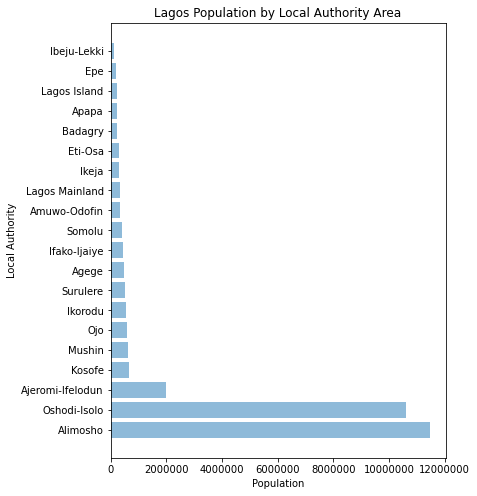

In [141]:
#Hor Bar chart with LA names
x_data = df_lag['Population']
y_data = df_lag['Local_Council']

plt.figure(figsize = (6, 8))
plt.ticklabel_format(style='plain')
plt.barh(y_data, x_data, align = 'center', alpha = 0.5)
plt.xlabel('Population')
plt.ylabel('Local Authority')
plt.title('Lagos Population by Local Authority Area')


plt.show()

#### Local Councils, Population and Waste in London

In [142]:
# Links to UK gov data on national pouplation and waste

In [143]:
lonurl = 'https://data.london.gov.uk/download/population-change-1939-2015/6fb637cf-d3c1-4456-a561-85cd995c020f/Population%20by%20borough%201939%20to%202039.xlsx'

In [144]:
# London population up to 2015
df_lon = pd.read_excel(lonurl)
df_lon.head(5)

Unnamed: 0                                         Unnamed: 1  \
0                  nan  Population estimates for London and boroughs, ...   
1                  nan                             (thousands of persons)   
2                  nan                                                NaN   
3                  nan                                                NaN   
4                  nan                                          Area Name   

          Unnamed: 2         Unnamed: 3 Unnamed: 4           Unnamed: 5  \
0                NaN                NaN        NaN                  nan   
1                NaN                NaN        NaN                  nan   
2                NaN                NaN        NaN                  nan   
3  mid-year estimate  mid-year estimate     Census                  nan   
4               1939               1988       2011                  nan   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9          Unnamed: 10  \
0         NaN         NaN         NaN         NaN                  nan   
1         NaN         NaN         NaN         NaN                  nan   
2         NaN         NaN         NaN         NaN                  nan   
3  Projection  Projection  Projection  Projection                  nan   
4        2015        2021        2031        2039                  nan   

         Unnamed: 11 Unnamed: 12          Unnamed: 13        Unnamed: 14  \
0                NaN         NaN                  nan                NaN   
1                NaN         NaN                  nan                NaN   
2                NaN         NaN                  nan                NaN   
3  Growth\n1939-2015         NaN                  nan  Growth\n2014-2015   
4                NaN         NaN                  nan                NaN   

  Unnamed: 15  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

##### Data cleaning and wrangling

In [145]:
df_lon.columns = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P'] # renaming the title for convenience
df_lon.head()

A                                                  B  \
0                  nan  Population estimates for London and boroughs, ...   
1                  nan                             (thousands of persons)   
2                  nan                                                NaN   
3                  nan                                                NaN   
4                  nan                                          Area Name   

                   C                  D       E                    F  \
0                NaN                NaN     NaN                  nan   
1                NaN                NaN     NaN                  nan   
2                NaN                NaN     NaN                  nan   
3  mid-year estimate  mid-year estimate  Census                  nan   
4               1939               1988    2011                  nan   

            G           H           I           J                    K  \
0         NaN         NaN         NaN         NaN                  nan   
1         NaN         NaN         NaN         NaN                  nan   
2         NaN         NaN         NaN         NaN                  nan   
3  Projection  Projection  Projection  Projection                  nan   
4        2015        2021        2031        2039                  nan   

                   L    M                    N                  O    P  
0                NaN  NaN                  nan                NaN  NaN  
1                NaN  NaN                  nan                NaN  NaN  
2                NaN  NaN                  nan                NaN  NaN  
3  Growth\n1939-2015  NaN                  nan  Growth\n2014-2015  NaN  
4                NaN  NaN                  nan                NaN  NaN

In [146]:
dcol = ['A','C','D','E','F','H','I','J','K','L','M','N','O','P']
df_lon.drop(dcol, axis = 1, inplace = True)  #dropping unneeded columns

In [147]:
df_lon.columns = ['Local_Council', 'Population'] # renaming columns
df_lon.head(10)

Local_Council           Population
0  Population estimates for London and boroughs, ...                  NaN
1                             (thousands of persons)                  NaN
2                                                NaN                  NaN
3                                                NaN           Projection
4                                          Area Name                 2015
5                                                NaN                  NaN
6                                     City of London                 8.10
7                               Barking and Dagenham               205.43
8                                             Barnet               393.22
9                                             Bexley               237.01

In [148]:
df_lon.tail(20) # checking the tail to understand how much to cut off from the sheet end

Local_Council           Population
34                                             Sutton               196.41
35                                      Tower Hamlets               284.32
36                                     Waltham Forest               271.43
37                                         Wandsworth               322.74
38                                        Westminster               230.54
39                                                NaN                  NaN
40                                       Inner London             3,440.31
41                                       Outer London             5,192.56
42                                     Greater London             8,632.87
43                                                NaN                  NaN
44                                                NaN                  NaN
45                                                NaN                  NaN
46                                           Sources:                  NaN
47  ONS population estimates, Open Government Licence                  NaN
48               2011 Census, Open Government Licence                  NaN
49            GLA 2013 round capped SHLAA projections                  NaN
50                                                NaN                  NaN
51                                                NaN                  NaN
52                                           Contact:                  NaN
53                           demography@london.gov.uk                  NaN

In [149]:
l1 = list(range(0,6))
l2 = list(range(39,54))
l3 = l1+l2
l3

[0, 1, 2, 3, 4, 5, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]

In [150]:
df_lon.drop(l3, axis = 0, inplace = True)
df_lon.reset_index(drop=True, inplace=True)
df_lon.head(10)

Local_Council           Population
0        City of London                 8.10
1  Barking and Dagenham               205.43
2                Barnet               393.22
3                Bexley               237.01
4                 Brent               326.34
5               Bromley               320.08
6                Camden               230.28
7               Croydon               381.17
8                Ealing               349.33
9               Enfield               322.14

In [151]:
df_lon.tail()

Local_Council           Population
28          Sutton               196.41
29   Tower Hamlets               284.32
30  Waltham Forest               271.43
31      Wandsworth               322.74
32     Westminster               230.54

In [152]:
df_lon.dtypes # check data types

Local_Council    object
Population       object
dtype: object

In [153]:
# remove decimal and multiply by thousand for Population to reflect Population as units 
df_lon['Population'] = df_lon['Population']*1000 
df_lon.head()

Local_Council           Population
0        City of London             8,101.78
1  Barking and Dagenham           205,434.87
2                Barnet           393,215.09
3                Bexley           237,012.32
4                 Brent           326,338.84

In [154]:
# convert Population to float type data for descriptive statistics
df_lon = df_lon.astype({'Local_Council':str, 'Population':float})
df_lon.dtypes

Local_Council     object
Population       float64
dtype: object

In [155]:
df_lon.shape

(33, 2)

In [156]:
df_lon.describe()

Population
count                33.00
mean            261,602.23
std              74,548.50
min               8,101.78
25%             220,784.22
50%             269,121.94
75%             320,083.39
max             393,215.09

In [157]:
df_lon[df_lon['Population'] == df_lon['Population'].min()]

Local_Council           Population
0  City of London             8,101.78

In [158]:
df_lon[df_lon['Population'] == df_lon['Population'].max()]

Local_Council           Population
2        Barnet           393,215.09

In [159]:
df_lon.sum()

Local_Council    City of LondonBarking and DagenhamBarnetBexley...
Population                                            8,632,873.44
dtype: object

In [160]:
## London Waste Data

In [161]:
ewurl = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/849136/LA_and_Regional_Spreadsheet_1819.xlsx'

In [162]:
df_ew = pd.read_excel(ewurl, sheet_name = 'Table_1')
df_ew.head()

Table 1: Local Authority Collected and Household Waste Statistics 2014-15 to 2018-19, England  \
0  For correct totals, you should only sum values...                                              
1                                                NaN                                              
2                                     Financial Year                                              
3                                            2014-15                                              
4                                            2014-15                                              

      Unnamed: 1 Unnamed: 2 Unnamed: 3  \
0            NaN        NaN        NaN   
1            NaN        NaN        NaN   
2         Region   ONS Code  JPP order   
3  East Midlands  E07000039         97   
4  East Midlands  E07000038         98   

                               Unnamed: 4      Unnamed: 5  \
0                                     NaN             NaN   
1                                     NaN             NaN   
2                         Local Authority  Authority type   
3       South Derbyshire District Council      Collection   
4  North East Derbyshire District Council      Collection   

                                       Unnamed: 6  \
0                                             NaN   
1                       Local authority collected   
2  Total local authority collected waste (tonnes)   
3                                           41155   
4                                           42486   

                         Unnamed: 7  \
0                               NaN   
1                        Households   
2  Household - total waste (tonnes)   
3                             39673   
4                             40578   

                                          Unnamed: 8  \
0                                                NaN   
1                                         Households   
2  Household - waste sent for recycling-compostin...   
3                                              19446   
4                                              17835   

                               Unnamed: 9  ...  \
0                                     NaN  ...   
1                              Households  ...   
2  Household dry recycling-reuse (tonnes)  ...   
3                                    7648  ...   
4                                    7988  ...   

                                         Unnamed: 13  \
0                                                NaN   
1                                         Households   
2  Household - civic amenity sites (not recycled)...   
3                                                  0   
4                                                  0   

                                         Unnamed: 14  \
0                                                NaN   
1                                         Households   
2  Household - other sources (not recycled) (tonnes)   
3                                               1510   
4                                               2094   

                              Unnamed: 15  \
0                                     NaN   
1                              Households   
2  Household - estimated rejects (tonnes)   
3                                     159   
4                                     711   

                            Unnamed: 16  \
0                                   NaN   
1                        Non-households   
2  Non-household - total waste (tonnes)   
3                                  1482   
4                                  1908   

                                         Unnamed: 17  \
0                                                NaN   
1                                     Non-households   
2  Non-household - waste sent for recycling-compo...   
3                                                121   
4                                                 -2   

                                         Unnamed: 18  

In [163]:
la=[2,3,5]
lb=list(range(12,23))
lc = la+lb
lc

[2, 3, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [164]:
df_ew.drop(df_ew.columns[lc], axis =1, inplace = True)
df_ew.reset_index(drop = True, inplace = True)
df_ew.head()

Table 1: Local Authority Collected and Household Waste Statistics 2014-15 to 2018-19, England  \
0  For correct totals, you should only sum values...                                              
1                                                NaN                                              
2                                     Financial Year                                              
3                                            2014-15                                              
4                                            2014-15                                              

      Unnamed: 1                              Unnamed: 4  \
0            NaN                                     NaN   
1            NaN                                     NaN   
2         Region                         Local Authority   
3  East Midlands       South Derbyshire District Council   
4  East Midlands  North East Derbyshire District Council   

                                       Unnamed: 6  \
0                                             NaN   
1                       Local authority collected   
2  Total local authority collected waste (tonnes)   
3                                           41155   
4                                           42486   

                         Unnamed: 7  \
0                               NaN   
1                        Households   
2  Household - total waste (tonnes)   
3                             39673   
4                             40578   

                                          Unnamed: 8  \
0                                                NaN   
1                                         Households   
2  Household - waste sent for recycling-compostin...   
3                                              19446   
4                                              17835   

                               Unnamed: 9  \
0                                     NaN   
1                              Households   
2  Household dry recycling-reuse (tonnes)   
3                                    7648   
4                                    7988   

                                Unnamed: 10  \
0                                       NaN   
1                                Households   
2  Household green recycling-reuse (tonnes)   
3                                     11798   
4                                      9847   

                                         Unnamed: 11  
0                                                NaN  
1                                         Households  
2  Household - waste not sent for recycling (tonnes)  
3                                              20227  
4                                              22744

In [165]:
df_ew.rename(columns=df_ew.iloc[2], inplace = True)
df_ew.drop([0,1,2], inplace = True)
df_ew.reset_index(drop=True, inplace=True)
df_ew.head()

Financial Year         Region                         Local Authority  \
0        2014-15  East Midlands       South Derbyshire District Council   
1        2014-15  East Midlands  North East Derbyshire District Council   
2        2014-15  East Midlands               High Peak Borough Council   
3        2014-15  East Midlands                 Erewash Borough Council   
4        2014-15  East Midlands       Derbyshire Dales District Council   

  Total local authority collected waste (tonnes)  \
0                                          41155   
1                                          42486   
2                                          40915   
3                                          47242   
4                                          30460   

  Household - total waste (tonnes)  \
0                            39673   
1                            40578   
2                            36616   
3                            45158   
4                            28190   

  Household - waste sent for recycling-composting-reuse (tonnes)  \
0                                              19446               
1                                              17835               
2                                              15676               
3                                              17549               
4                                              15574               

  Household dry recycling-reuse (tonnes)  \
0                                   7648   
1                                   7988   
2                                   8289   
3                                   7950   
4                                   7119   

  Household green recycling-reuse (tonnes)  \
0                                    11798   
1                                     9847   
2                                     7387   
3                                     9598   
4                                     8455   

  Household - waste not sent for recycling (tonnes)  
0                                             20227  
1                                             22744  
2                                             20940  
3                                             27609  
4                                             12616

In [166]:
df_ew.dropna(subset=['Region'], axis = 0, inplace = True)
df_ew.reset_index(drop=True, inplace=True)

In [167]:
df_ew.shape

(1743, 9)

In [168]:
# Extract data for London only for 2018-19 
df_lw = df_ew[(df_ew['Region']=='London') &  (df_ew['Financial Year']=='2018-19')]
df_lw.head()

Financial Year  Region          Local Authority  \
1405        2018-19  London  Barking and Dagenham LB   
1406        2018-19  London                Barnet LB   
1417        2018-19  London                 Brent LB   
1426        2018-19  London                Camden LB   
1449        2018-19  London                Ealing LB   

     Total local authority collected waste (tonnes)  \
1405                                          95567   
1406                                         155299   
1417                                         107801   
1426                                         102007   
1449                                         119074   

     Household - total waste (tonnes)  \
1405                            86072   
1406                           140316   
1417                            94326   
1426                            56807   
1449                            81369   

     Household - waste sent for recycling-composting-reuse (tonnes)  \
1405                                              20391               
1406                                              48578               
1417                                              34548               
1426                                              17652               
1449                                              42778               

     Household dry recycling-reuse (tonnes)  \
1405                                  12307   
1406                                  30544   
1417                                  22378   
1426                                  13377   
1449                                  28872   

     Household green recycling-reuse (tonnes)  \
1405                                     8084   
1406                                    18034   
1417                                    12170   
1426                                     4275   
1449                                    13906   

     Household - waste not sent for recycling (tonnes)  
1405                                             65681  
1406                                             91739  
1417                                             59778  
1426                                             39155  
1449                                             38591

In [169]:
df_lw.shape

(37, 9)

In [170]:
#some summary stats with data including recycled amounts 
df_lw.min()

Financial Year                                                                    2018-19
Region                                                                             London
Local Authority                                                   Barking and Dagenham LB
Total local authority collected waste (tonnes)                                       3985
Household - total waste (tonnes)                                                     3818
Household - waste sent for recycling-composting-reuse (tonnes)                       1140
Household dry recycling-reuse (tonnes)                                                875
Household green recycling-reuse (tonnes)                                              265
Household - waste not sent for recycling (tonnes)                                    2678
dtype: object

In [171]:
df_lw.max()

Financial Year                                                                     2018-19
Region                                                                              London
Local Authority                                                   Westminster City Council
Total local authority collected waste (tonnes)                                      818285
Household - total waste (tonnes)                                                    674705
Household - waste sent for recycling-composting-reuse (tonnes)                      211542
Household dry recycling-reuse (tonnes)                                              134234
Household green recycling-reuse (tonnes)                                             84060
Household - waste not sent for recycling (tonnes)                                   474865
dtype: object

In [172]:
df_lw.sum()

Financial Year                                                    2018-192018-192018-192018-192018-192018-192018...
Region                                                            LondonLondonLondonLondonLondonLondonLondonLond...
Local Authority                                                   Barking and Dagenham LBBarnet LBBrent LBCamden...
Total local authority collected waste (tonnes)                                                              5882973
Household - total waste (tonnes)                                                                            4823511
Household - waste sent for recycling-composting-reuse (tonnes)                                              1578563
Household dry recycling-reuse (tonnes)                                                                      1032807
Household green recycling-reuse (tonnes)                                                                     545752
Household - waste not sent for recycling (tonnes)                       

In [173]:
# focussing on Household waste data
lwc = [0,1,3,5,6,7,8]
df_lhhw = df_lw.drop(df_lw.columns[lwc], axis =1)
df_lhhw.reset_index(drop = True, inplace = True)
df_lhhw.head()

Local Authority Household - total waste (tonnes)
0  Barking and Dagenham LB                            86072
1                Barnet LB                           140316
2                 Brent LB                            94326
3                Camden LB                            56807
4                Ealing LB                            81369

In [174]:
df_lhhw.shape

(37, 2)

In [175]:
# convert  Waste column to float type data for descriptive statistics
df_lhhw = df_lhhw.astype({'Local Authority':str, 'Household - total waste (tonnes)':float})
df_lhhw.dtypes

Local Authority                      object
Household - total waste (tonnes)    float64
dtype: object

In [176]:
df_lhhw.sort_values(by="Household - total waste (tonnes)", ascending = False, inplace = True)
df_lhhw.head()

Local Authority  Household - total waste (tonnes)
22       North London Waste Authority                        674,705.00
23        West London Waste Authority                        563,327.00
21        East London Waste Authority                        412,069.00
24  Western Riverside Waste Authority                        288,839.00
1                           Barnet LB                        140,316.00

In [177]:
# Waste Authority data are aggregates of some Local Boroughs grouped together so they can be removed to avoid double counting

df_lhhw.drop([21, 22, 23, 24], inplace = True)
df_lhhw.reset_index(drop = True)
df_lhhw.head()

Local Authority  Household - total waste (tonnes)
1        Barnet LB                        140,316.00
28      Croydon LB                        127,946.00
15       Newham LB                        120,309.00
26      Bromley LB                        119,926.00
5       Enfield LB                        118,449.00

In [178]:
df_lhhw.shape

(33, 2)

In [179]:
df_lhhw.describe()

Household - total waste (tonnes)
count                             33.00
mean                          87,411.24
std                           26,847.77
min                            3,818.00
25%                           73,917.00
50%                           89,640.00
75%                          102,204.00
max                          140,316.00

In [180]:
df_lhhw[df_lhhw['Household - total waste (tonnes)'] == df_lhhw['Household - total waste (tonnes)'].min()]

Local Authority  Household - total waste (tonnes)
27  City of London                          3,818.00

In [181]:
df_lhhw[df_lhhw['Household - total waste (tonnes)'] == df_lhhw['Household - total waste (tonnes)'].max()]

Local Authority  Household - total waste (tonnes)
1       Barnet LB                        140,316.00

In [182]:
df_lhhw.sum()

Local Authority                     Barnet LBCroydon LBNewham LBBromley LBEnfield ...
Household - total waste (tonnes)                                         2,884,571.00
dtype: object

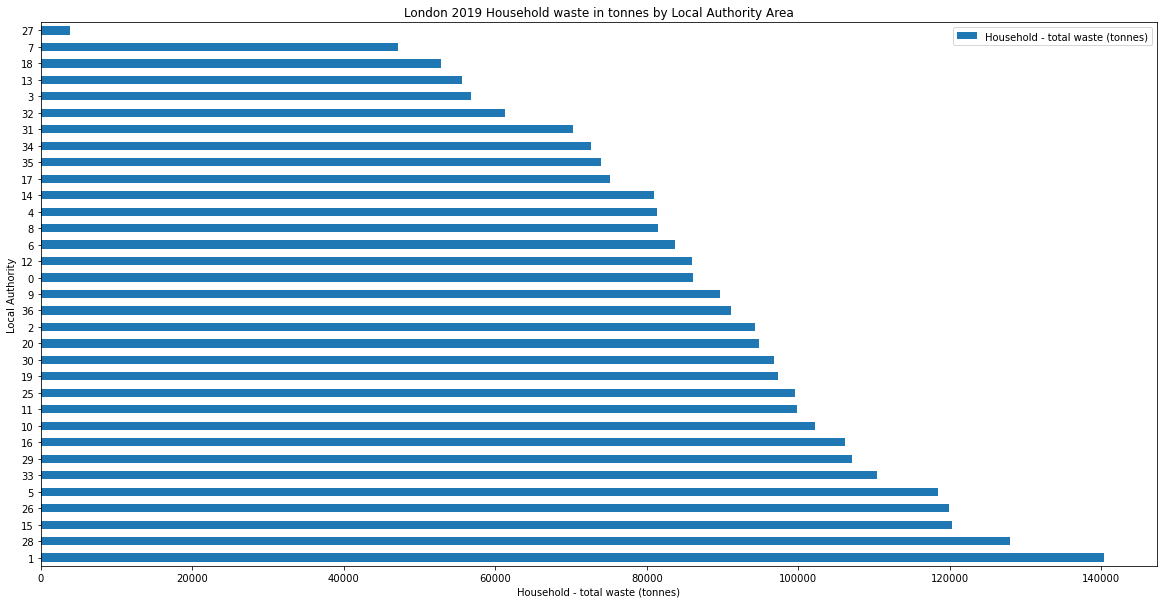

In [183]:
#simple chart using pandas
df_lhhw.plot(kind='barh', figsize = (20, 10))
plt.title('London 2019 Household waste in tonnes by Local Authority Area')
plt.ylabel('Local Authority')
plt.xlabel("Household - total waste (tonnes)")

plt.show()

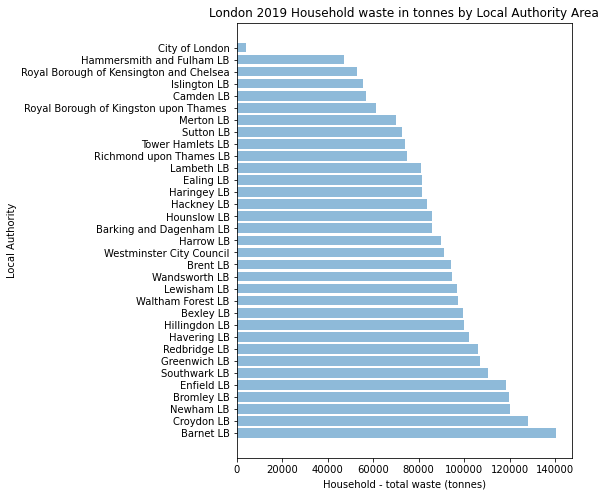

In [184]:
#Hor Bar chart with LA names
x_data = df_lhhw['Household - total waste (tonnes)']
y_data = df_lhhw['Local Authority']

plt.figure(figsize = (6, 8))
plt.barh(y_data, x_data, align = 'center', alpha = 0.5)
plt.xlabel("Household - total waste (tonnes)")
plt.ylabel('Local Authority')
plt.title('London 2019 Household waste in tonnes by Local Authority Area')

plt.show()

In [185]:
###Checking All England Waste stat for 2018-19

In [186]:
df_ewy = df_ew[['Financial Year', 'Local Authority', 'Household - total waste (tonnes)']]
df_ewy.head()

Financial Year                         Local Authority  \
0        2014-15       South Derbyshire District Council   
1        2014-15  North East Derbyshire District Council   
2        2014-15               High Peak Borough Council   
3        2014-15                 Erewash Borough Council   
4        2014-15       Derbyshire Dales District Council   

  Household - total waste (tonnes)  
0                            39673  
1                            40578  
2                            36616  
3                            45158  
4                            28190

In [187]:
df_ewy.shape

(1743, 3)

In [188]:
df_ew19 = df_ewy[(df_ewy['Financial Year'] == '2018-19')]
df_ew19.reset_index(drop = True, inplace = True)
df_ew19.head()

Financial Year               Local Authority  \
0        2018-19         Adur District Council   
1        2018-19     Allerdale Borough Council   
2        2018-19  Amber Valley Borough Council   
3        2018-19         Arun District Council   
4        2018-19     Ashfield District Council   

  Household - total waste (tonnes)  
0                            21153  
1                            41187  
2                            45826  
3                            55593  
4                            45939

In [189]:
df_ew19.shape

(345, 3)

In [190]:
# convert  Waste column to float type data for descriptive statistics
df_ew19 = df_ew19.astype({'Local Authority':str, 'Household - total waste (tonnes)':float})
df_ew19.dtypes

Financial Year                       object
Local Authority                      object
Household - total waste (tonnes)    float64
dtype: object

In [191]:
df_ew19.describe()

Household - total waste (tonnes)
count                            345.00
mean                          97,900.84
std                          123,375.09
min                            1,630.00
25%                           38,547.00
50%                           53,679.00
75%                           99,231.00
max                          996,905.00

In [192]:
df_ew19[df_ew19['Household - total waste (tonnes)'] == df_ew19['Household - total waste (tonnes)'].min()]

Financial Year                 Local Authority  \
272        2018-19  Council of the Isles of Scilly   

     Household - total waste (tonnes)  
272                          1,630.00

In [193]:
df_ew19[df_ew19['Household - total waste (tonnes)'] == df_ew19['Household - total waste (tonnes)'].max()]

Financial Year               Local Authority  \
231        2018-19  Greater Manchester WDA (MBC)   

     Household - total waste (tonnes)  
231                        996,905.00

In [194]:
df_ew19.sum()

Financial Year                      2018-192018-192018-192018-192018-192018-192018...
Local Authority                     Adur District CouncilAllerdale Borough Council...
Household - total waste (tonnes)                                        33,775,790.00
dtype: object

#### London Population 2 - 2019

In [195]:
epurl = 'https://download.ons.gov.uk/downloads/filter-outputs/9a7d4449-c601-4e8d-b23b-ee791f6b52aa.xlsx'

In [196]:
# London Population data up to 2019 (more recent source/estimates)
df_ep = pd.read_excel('Eng-Pop-Est-2014-2019.xlsx')
df_ep.head()

Title  \
0           NaN   
1     Geography   
2          Adur   
3     Allerdale   
4  Amber Valley   

  Population Estimates for UK, England and Wales, Scotland and Northern Ireland  \
0                                                NaN                              
1                                     Geography code                              
2                                          E07000223                              
3                                          E07000026                              
4                                          E07000032                              

  Unnamed: 2 Unnamed: 3           Unnamed: 4           Unnamed: 5  \
0        NaN        NaN                  nan                  nan   
1        Sex        Age             2,014.00             2,015.00   
2        All      Total            63,266.00            63,526.00   
3        All      Total            96,532.00            96,756.00   
4        All      Total           124,050.00           124,188.00   

            Unnamed: 6           Unnamed: 7           Unnamed: 8  \
0                  nan                  nan                  nan   
1             2,016.00             2,017.00             2,018.00   
2            63,621.00            63,721.00            63,869.00   
3            97,099.00            97,213.00            97,527.00   
4           124,802.00           125,898.00           126,678.00   

            Unnamed: 9  
0                  nan  
1             2,019.00  
2            64,301.00  
3            97,761.00  
4           128,147.00

In [197]:
df_ep.rename(columns=df_ep.iloc[1], inplace = True)
df_ep.head()

Geography  Geography code  Sex    Age               2014.0  \
0           NaN             NaN  NaN    NaN                  nan   
1     Geography  Geography code  Sex    Age             2,014.00   
2          Adur       E07000223  All  Total            63,266.00   
3     Allerdale       E07000026  All  Total            96,532.00   
4  Amber Valley       E07000032  All  Total           124,050.00   

                2015.0               2016.0               2017.0  \
0                  nan                  nan                  nan   
1             2,015.00             2,016.00             2,017.00   
2            63,526.00            63,621.00            63,721.00   
3            96,756.00            97,099.00            97,213.00   
4           124,188.00           124,802.00           125,898.00   

                2018.0               2019.0  
0                  nan                  nan  
1             2,018.00             2,019.00  
2            63,869.00            64,301.00  
3            97,527.00            97,761.00  
4           126,678.00           128,147.00

In [198]:
df_ep.drop(index = [0,1], inplace = True)
df_ep.reset_index(drop = True, inplace = True)
df_ep.head()

Geography Geography code  Sex    Age               2014.0  \
0          Adur      E07000223  All  Total            63,266.00   
1     Allerdale      E07000026  All  Total            96,532.00   
2  Amber Valley      E07000032  All  Total           124,050.00   
3          Arun      E07000224  All  Total           154,653.00   
4      Ashfield      E07000170  All  Total           122,490.00   

                2015.0               2016.0               2017.0  \
0            63,526.00            63,621.00            63,721.00   
1            96,756.00            97,099.00            97,213.00   
2           124,188.00           124,802.00           125,898.00   
3           155,798.00           157,287.00           158,657.00   
4           123,577.00           124,513.00           126,164.00   

                2018.0               2019.0  
0            63,869.00            64,301.00  
1            97,527.00            97,761.00  
2           126,678.00           128,147.00  
3           159,827.00           160,758.00  
4           127,151.00           127,918.00

In [199]:
df_ep2 = df_ep.drop(['Geography code', 'Sex', 'Age'], axis = 1)
df_ep2.head()

Geography               2014.0               2015.0  \
0          Adur            63,266.00            63,526.00   
1     Allerdale            96,532.00            96,756.00   
2  Amber Valley           124,050.00           124,188.00   
3          Arun           154,653.00           155,798.00   
4      Ashfield           122,490.00           123,577.00   

                2016.0               2017.0               2018.0  \
0            63,621.00            63,721.00            63,869.00   
1            97,099.00            97,213.00            97,527.00   
2           124,802.00           125,898.00           126,678.00   
3           157,287.00           158,657.00           159,827.00   
4           124,513.00           126,164.00           127,151.00   

                2019.0  
0            64,301.00  
1            97,761.00  
2           128,147.00  
3           160,758.00  
4           127,918.00

In [200]:
df_ep19 = df_ep2[['Geography', 2019.0]]
df_ep19.head()

Geography               2019.0
0          Adur            64,301.00
1     Allerdale            97,761.00
2  Amber Valley           128,147.00
3          Arun           160,758.00
4      Ashfield           127,918.00

In [201]:
df_ep19.dtypes

Geography     object
2019.0       float64
dtype: object

In [202]:
df_ep19.rename(columns = {'Geography': 'Local Authorityp', 2019.0: 'Population'}, inplace = True)
df_ep19.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Local Authorityp           Population
0             Adur            64,301.00
1        Allerdale            97,761.00
2     Amber Valley           128,147.00
3             Arun           160,758.00
4         Ashfield           127,918.00

In [203]:
df_ep19.shape

(314, 2)

In [204]:
df_ep19.describe()

Population
count               314.00
mean            179,257.84
std             122,388.26
min               2,224.00
25%             101,588.50
50%             140,270.50
75%             222,357.25
max           1,141,816.00

In [205]:
df_ep19[df_ep19['Population'] == df_ep19['Population'].min()]

Local Authorityp           Population
136  Isles of Scilly             2,224.00

In [206]:
df_ep19[df_ep19['Population'] == df_ep19['Population'].max()]

Local Authorityp           Population
17       Birmingham         1,141,816.00

In [207]:
#London only 2019 Population
df_lp19 = df_ep[df_ep['Geography code'].str.contains("E09", case = False)]
df_lp19.head()

Geography Geography code  Sex    Age               2014.0  \
7   Barking and Dagenham      E09000002  All  Total           198,650.00   
8                 Barnet      E09000003  All  Total           373,745.00   
16                Bexley      E09000004  All  Total           240,016.00   
29                 Brent      E09000005  All  Total           320,101.00   
34               Bromley      E09000006  All  Total           321,602.00   

                 2015.0               2016.0               2017.0  \
7            203,101.00           208,182.00           210,711.00   
8            378,778.00           384,774.00           387,803.00   
16           242,387.00           245,095.00           246,124.00   
29           323,443.00           326,427.00           329,102.00   
34           325,303.00           327,580.00           329,391.00   

                 2018.0               2019.0  
7            211,998.00           212,906.00  
8            392,140.00           395,869.00  
16           247,258.00           248,287.00  
29           330,795.00           329,771.00  
34           331,096.00           332,336.00

In [208]:
df_lp19 = df_lp19[['Geography', 2019.0]].reset_index(drop=True)
df_lp19.rename(columns = {'Geography': 'Local Authorityl', 2019.0:'Population'}, inplace = True)
df_lp19.head()

Local Authorityl           Population
0  Barking and Dagenham           212,906.00
1                Barnet           395,869.00
2                Bexley           248,287.00
3                 Brent           329,771.00
4               Bromley           332,336.00

In [209]:
df_lp19.head()

Local Authorityl           Population
0  Barking and Dagenham           212,906.00
1                Barnet           395,869.00
2                Bexley           248,287.00
3                 Brent           329,771.00
4               Bromley           332,336.00

In [210]:
df_lp19.describe()

Population
count                33.00
mean            271,575.42
std              75,869.63
min               9,721.00
25%             242,467.00
50%             276,983.00
75%             326,034.00
max             395,869.00

In [211]:
df_lp19[df_lp19['Population'] == df_lp19['Population'].min()]

Local Authorityl           Population
6   City of London             9,721.00

In [212]:
df_lp19[df_lp19['Population'] == df_lp19['Population'].max()]

Local Authorityl           Population
1           Barnet           395,869.00

In [213]:
df_lp19.sum()

Local Authorityl    Barking and DagenhamBarnetBexleyBrentBromleyCa...
Population                                               8,961,989.00
dtype: object

In [214]:
df_lp19.sort_values(by="Population", ascending = False, inplace = True)
df_lp19.head()

Local Authorityl           Population
1            Barnet           395,869.00
7           Croydon           386,710.00
24           Newham           353,134.00
8            Ealing           341,806.00
9           Enfield           333,794.00

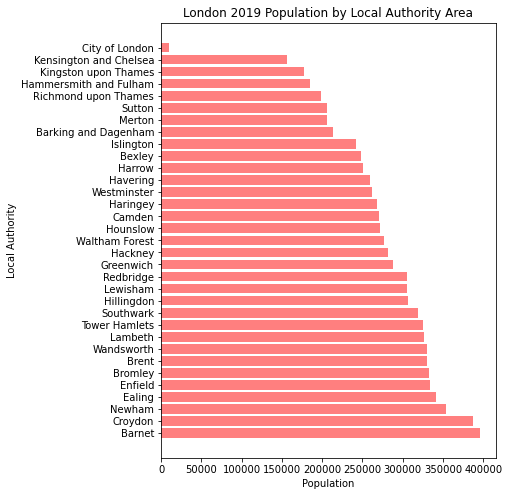

In [215]:
#Hor Bar chart with LA names
x_data = df_lp19['Population']
y_data = df_lp19['Local Authorityl']

plt.figure(figsize = (6, 8))
plt.barh(y_data, x_data, align = 'center', color = 'r', alpha = 0.5)
plt.xlabel("Population")
plt.ylabel('Local Authority')
plt.title('London 2019 Population by Local Authority Area')

plt.show()

In [216]:
# To join population and waste tables, normal merging does not work as the names of Local Authorities do not exactly match
#So I'm using a fuzzy-merge from difflib library

In [217]:
import difflib 

def fuzzy_merge(df1, df2, left_on, right_on, how='inner', cutoff=0.6):
    df_other= df2.copy()
    df_other[left_on] = [get_closest_match(x, df1[left_on], cutoff) 
                         for x in df_other[right_on]]
    return df1.merge(df_other, on=left_on, how=how)

def get_closest_match(x, other, cutoff):
    matches = difflib.get_close_matches(x, other, cutoff=cutoff)
    return matches[0] if matches else None

In [218]:
df_ctbll = fuzzy_merge(df_lp19, df_lhhw, left_on = 'Local Authorityl', right_on = 'Local Authority')
print (df_ctbll.shape)
df_ctbll.head(10)

(33, 4)


Local Authorityl           Population   Local Authority  \
0           Barnet           395,869.00         Barnet LB   
1          Croydon           386,710.00        Croydon LB   
2           Newham           353,134.00         Newham LB   
3           Ealing           341,806.00         Ealing LB   
4          Enfield           333,794.00        Enfield LB   
5          Bromley           332,336.00        Bromley LB   
6            Brent           329,771.00          Brent LB   
7       Wandsworth           329,677.00     Wandsworth LB   
8          Lambeth           326,034.00        Lambeth LB   
9    Tower Hamlets           324,745.00  Tower Hamlets LB   

   Household - total waste (tonnes)  
0                        140,316.00  
1                        127,946.00  
2                        120,309.00  
3                         81,369.00  
4                        118,449.00  
5                        119,926.00  
6                         94,326.00  
7                         94,840.00  
8                         80,966.00  
9                         73,917.00

In [219]:
df_ctbll.drop(df_ctbll.columns[[2]], axis = 1, inplace = True)
df_ctbll.head()

Local Authorityl           Population  Household - total waste (tonnes)
0           Barnet           395,869.00                        140,316.00
1          Croydon           386,710.00                        127,946.00
2           Newham           353,134.00                        120,309.00
3           Ealing           341,806.00                         81,369.00
4          Enfield           333,794.00                        118,449.00

In [220]:
#check for missing values in the table 
df_ctbll.isnull().head()

Local Authorityl  Population  Household - total waste (tonnes)
0             False       False                             False
1             False       False                             False
2             False       False                             False
3             False       False                             False
4             False       False                             False

In [221]:
# in case there are any, remove rows where there is no population figures or Local Authorityp name
df_ctbll.dropna(subset=['Population', 'Household - total waste (tonnes)' ], axis = 0, inplace = True)
df_ctbll.reset_index(drop = True, inplace = True)
df_ctbll.head()

Local Authorityl           Population  Household - total waste (tonnes)
0           Barnet           395,869.00                        140,316.00
1          Croydon           386,710.00                        127,946.00
2           Newham           353,134.00                        120,309.00
3           Ealing           341,806.00                         81,369.00
4          Enfield           333,794.00                        118,449.00

In [222]:
df_ctbll.describe()

Population  Household - total waste (tonnes)
count                33.00                             33.00
mean            271,575.42                         87,411.24
std              75,869.63                         26,847.77
min               9,721.00                          3,818.00
25%             242,467.00                         73,917.00
50%             276,983.00                         89,640.00
75%             326,034.00                        102,204.00
max             395,869.00                        140,316.00

In [223]:
#data sort by waste in descending order
df_ctbll_wsort = df_ctbll.sort_values(by="Household - total waste (tonnes)", ascending = False)
df_ctbll_wsort.head()

Local Authorityl           Population  Household - total waste (tonnes)
0           Barnet           395,869.00                        140,316.00
1          Croydon           386,710.00                        127,946.00
2           Newham           353,134.00                        120,309.00
5          Bromley           332,336.00                        119,926.00
4          Enfield           333,794.00                        118,449.00

In [224]:
#data sort by waste in descending order
df_ctbll_psort = df_ctbll.sort_values(by="Population", ascending = False)
df_ctbll_psort.head()

Local Authorityl           Population  Household - total waste (tonnes)
0           Barnet           395,869.00                        140,316.00
1          Croydon           386,710.00                        127,946.00
2           Newham           353,134.00                        120,309.00
3           Ealing           341,806.00                         81,369.00
4          Enfield           333,794.00                        118,449.00

In [225]:
import difflib 

def fuzzy_merge(df1, df2, left_on, right_on, how='inner', cutoff=0.46):
    df_other= df2.copy()
    df_other[left_on] = [get_closest_match(x, df1[left_on], cutoff) 
                         for x in df_other[right_on]]
    return df1.merge(df_other, on=left_on, how=how)

def get_closest_match(x, other, cutoff):
    matches = difflib.get_close_matches(x, other, cutoff=cutoff)
    return matches[0] if matches else None

In [226]:
#After multiple attempts, I found 0.46 to be ideal cutoff to match all the data for my left table  
#Doing another fuzzy merge because the local authority names are not exact matches on the population and waste dataframes for Total England tables

df_ctble = fuzzy_merge(df_ep19, df_ew19, left_on = 'Local Authorityp', right_on = 'Local Authority', how = 'left')
print (df_ctble.shape)
df_ctble.tail(5)

(370, 5)


Local Authorityp           Population Financial Year  \
365         Worthing           110,570.00            NaN   
366         Wychavon           129,433.00        2018-19   
367             Wyre           112,091.00            NaN   
368      Wyre Forest           101,291.00        2018-19   
369             York           210,618.00            NaN   

                  Local Authority  Household - total waste (tonnes)  
365                           NaN                               nan  
366     Wychavon District Council                         46,980.00  
367                           NaN                               nan  
368  Wyre Forest District Council                         35,696.00  
369                           NaN                               nan

In [227]:
df_ctble.drop(df_ctble.columns[[2,3]], axis = 1, inplace = True)
df_ctble.head()

Local Authorityp           Population  Household - total waste (tonnes)
0             Adur            64,301.00                               nan
1        Allerdale            97,761.00                         41,187.00
2     Amber Valley           128,147.00                         45,826.00
3             Arun           160,758.00                               nan
4         Ashfield           127,918.00                         45,939.00

In [228]:
#check for missing values in the table 
df_ctble.isnull()

Local Authorityp  Population  Household - total waste (tonnes)
0               False       False                              True
1               False       False                             False
2               False       False                             False
3               False       False                              True
4               False       False                             False
..                ...         ...                               ...
365             False       False                              True
366             False       False                             False
367             False       False                              True
368             False       False                             False
369             False       False                              True

[370 rows x 3 columns]

In [229]:
# remove rows where there is no population figures or Local Authorityp name
df_ctble.dropna(subset=['Population', 'Household - total waste (tonnes)'], axis = 0, inplace = True)
df_ctble.reset_index(drop = True, inplace = True)
df_ctble.head()

Local Authorityp           Population  Household - total waste (tonnes)
0             Allerdale            97,761.00                         41,187.00
1          Amber Valley           128,147.00                         45,826.00
2              Ashfield           127,918.00                         45,939.00
3               Ashford           130,032.00                         41,729.00
4  Barking and Dagenham           212,906.00                         86,072.00

In [230]:
df_ctble.describe()

Population  Household - total waste (tonnes)
count               314.00                            314.00
mean            187,361.73                        100,416.58
std             124,729.44                        123,547.32
min               2,224.00                          1,630.00
25%             101,462.00                         39,772.25
50%             148,873.00                         55,015.50
75%             226,022.25                        102,714.75
max           1,141,816.00                        996,905.00

In [231]:
#data sort by waste in descending order
df_ctble_wsort = df_ctble.sort_values(by="Household - total waste (tonnes)", ascending = False)
df_ctble_wsort.head()

Local Authorityp           Population  \
168                Manchester           552,858.00   
61              County Durham           530,094.00   
62              County Durham           530,094.00   
184     North East Derbyshire           101,462.00   
126  Herefordshire, County of           192,801.00   

     Household - total waste (tonnes)  
168                        996,905.00  
61                         680,775.00  
62                         676,053.00  
184                        674,705.00  
126                        607,359.00

In [232]:
#Data sort by Population in descending order
df_ctble_psort = df_ctble.sort_values(by="Population", ascending = False)
df_ctble_psort.head()

Local Authorityp           Population  Household - total waste (tonnes)
15        Birmingham         1,141,816.00                        412,130.00
232        Sheffield           584,853.00                        185,487.00
59          Cornwall           569,578.00                        263,354.00
167       Manchester           552,858.00                        155,619.00
168       Manchester           552,858.00                        996,905.00

In [233]:
#add category column to identify London Local Authorities:
#first creat a list from the 'local authority columns'
ctbll_list = df_ctbll['Local Authorityl'].tolist()
ctble_list = df_ctble['Local Authorityp'].tolist()

In [234]:
df_ctble['Category'] = np.where(df_ctble['Local Authorityp'].isin(ctbll_list), 'London_LA', 'Outside_Lon')
df_ctble.head(10)

Local Authorityp           Population  \
0              Allerdale            97,761.00   
1           Amber Valley           128,147.00   
2               Ashfield           127,918.00   
3                Ashford           130,032.00   
4   Barking and Dagenham           212,906.00   
5                 Barnet           395,869.00   
6               Barnsley           246,866.00   
7      Barrow-in-Furness            67,049.00   
8               Basildon           187,199.00   
9  Basingstoke and Deane           176,582.00   

   Household - total waste (tonnes)     Category  
0                         41,187.00  Outside_Lon  
1                         45,826.00  Outside_Lon  
2                         45,939.00  Outside_Lon  
3                         41,729.00  Outside_Lon  
4                         86,072.00    London_LA  
5                        140,316.00    London_LA  
6                         99,468.00  Outside_Lon  
7                         24,394.00  Outside_Lon  
8                         77,360.00  Outside_Lon  
9                         58,435.00  Outside_Lon

## Visualisation of waste and population dataset

In [235]:
import itertools
import matplotlib as mpl
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
from scipy import stats
import seaborn as sns


print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.3.2


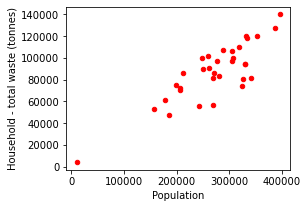

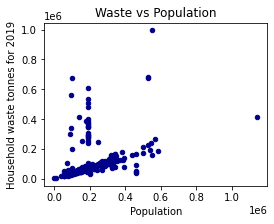

In [236]:
#Quck checks with scatter plots
df_ctbll.plot(kind = 'scatter', x = 'Population', y = 'Household - total waste (tonnes)', figsize=(4, 3), color='red')

df_ctble.plot(kind = 'scatter', x = 'Population', y = 'Household - total waste (tonnes)', figsize=(4, 3), color='darkblue')

plt.title('Waste vs Population')
plt.xlabel('Population')
plt.ylabel('Household waste tonnes for 2019')

plt.show()

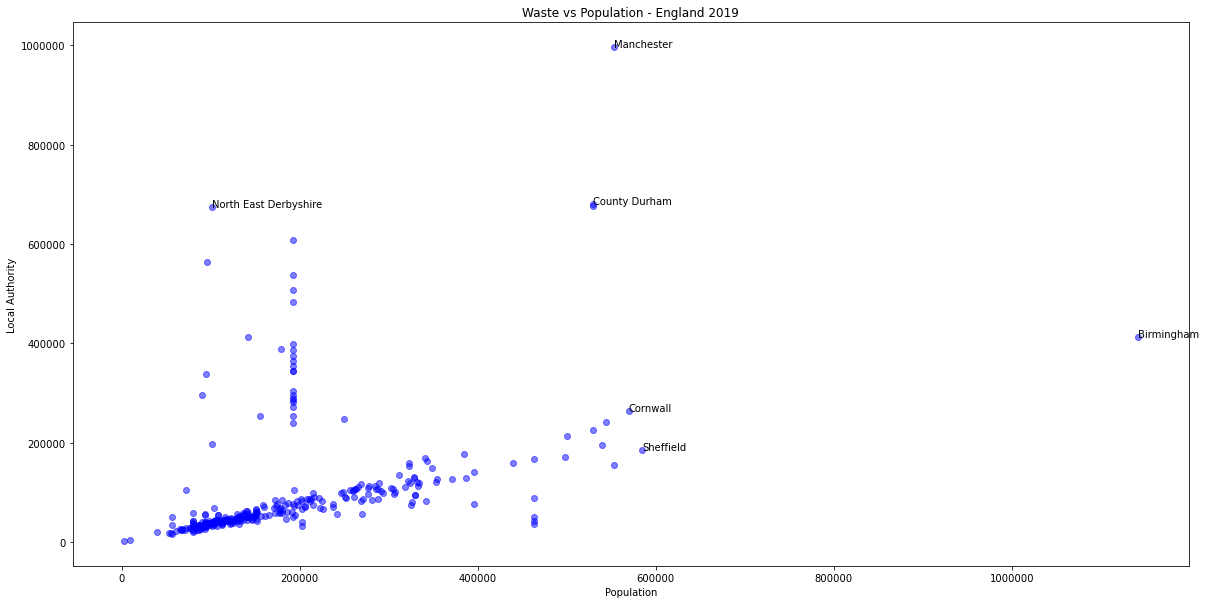

In [237]:
# different plot
x = df_ctble['Population']
y = df_ctble['Household - total waste (tonnes)']
n = df_ctble['Local Authorityp']
coll= df_ctble['Category']

plt.figure(figsize = (20, 10))
plt.scatter(x, y, color = 'b', alpha = 0.5)
plt.ticklabel_format(style='plain')
plt.title('Waste vs Population - England 2019')
plt.xlabel('Population')
plt.ylabel('Local Authority')

# Annotate top 3 populated LAs using indexes from tables sorted by population 
plt.annotate(n[15], (x[15], y[15]))
plt.annotate(n[232], (x[232], y[232]))
plt.annotate(n[59], (x[59], y[59]))

# Annotate top 3 waste generating LAs using indexes from tables sorted by waste 
plt.annotate(n[168], (x[168], y[168]))
plt.annotate(n[61], (x[61], y[61]))
plt.annotate(n[184], (x[184], y[184]))

plt.show()

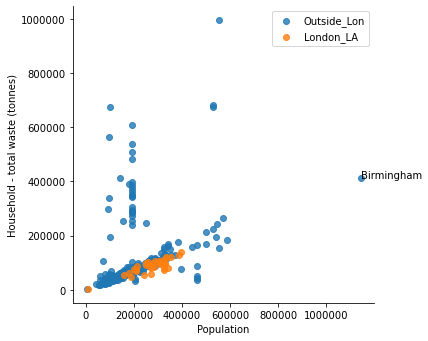

In [238]:
# different plot with seaborn showing london LAs in separate colour category

sns.lmplot('Population', 'Household - total waste (tonnes)', data=df_ctble, hue='Category', fit_reg=False, legend = False)
plt.legend(loc='upper right')
plt.ticklabel_format(style='plain')
plt.annotate(n[15], (x[15], y[15]))
plt.show()

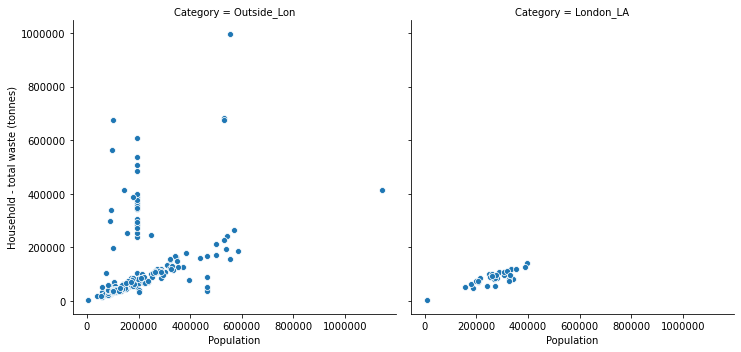

In [239]:
sns.relplot(data= df_ctble, x="Population", y="Household - total waste (tonnes)", col="Category", kind="scatter")
plt.ticklabel_format(style='plain')

## Attempts at regression and fitting the data

In [240]:
#checking for linear correlation England wide
df_ctble[['Population', 'Household - total waste (tonnes)']].corr()

Population  \
Population                                       1.00   
Household - total waste (tonnes)                 0.43   

                                  Household - total waste (tonnes)  
Population                                                    0.43  
Household - total waste (tonnes)                              1.00

In [241]:
#checking for linear correlation London wide
df_ctbll[['Population', 'Household - total waste (tonnes)']].corr()

Population  \
Population                                       1.00   
Household - total waste (tonnes)                 0.85   

                                  Household - total waste (tonnes)  
Population                                                    0.85  
Household - total waste (tonnes)                              1.00

The Pearson Correlation Coeff is: 0.4335  with a P-value of P: 0.00000000000000080452
The Pearson Correlation Coeff is: 0.8490  with a P-value of P: 0.00000000042856603974


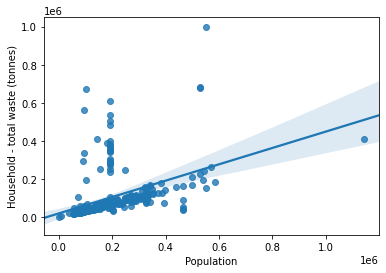

In [242]:
#In both instances not a strong correlation was observed given the pearson corr coef.
#confirm with reg plot and p value

sns.regplot(x='Population', y='Household - total waste (tonnes)', data=df_ctble)

pearson_coef, p_value = stats.pearsonr(df_ctble['Population'], df_ctble['Household - total waste (tonnes)'])
pearson_coef2, p_value2 = stats.pearsonr(df_ctbll['Population'], df_ctbll['Household - total waste (tonnes)'])

print("The Pearson Correlation Coeff is:", "%.4f" % pearson_coef, " with a P-value of P:", "%.20f" % p_value)  
print("The Pearson Correlation Coeff is:", "{:.4f}".format(pearson_coef2), " with a P-value of P:", "{:.20f}".format(p_value2)) 

<AxesSubplot:xlabel='Population', ylabel='Household - total waste (tonnes)'>

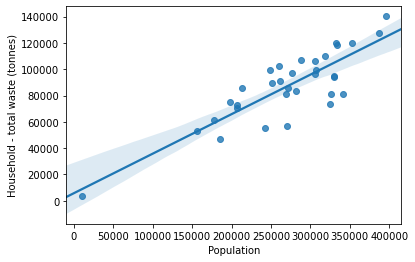

In [243]:
sns.regplot(x='Population', y='Household - total waste (tonnes)', data=df_ctbll)

Coefficients:  [[0.28362162]]
Intercept:  [12153.47160597]
Mean absolute error: 11066.34
Residual sum of squares (MSE): 200547282.95
R2-score: 0.76


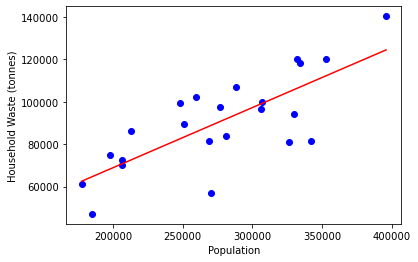

In [244]:
# Training the model and checking the error

# Split London data to train and test sets, fit a linear model to the train data, test with test data
#checkin accuracy of models
from sklearn import linear_model
from sklearn.metrics import r2_score

msk = np.random.rand(len(df_ctbll)) < 0.8
train = df_ctbll[msk]
test = df_ctbll[~msk]

train_x = np.asanyarray(train[['Population']])
train_y = np.asanyarray(train[['Household - total waste (tonnes)']])
test_x = np.asanyarray(test[['Population']])
test_y = np.asanyarray(test[['Household - total waste (tonnes)']])

lreg = linear_model.LinearRegression()
mdel = lreg.fit(train_x, train_y)
y_hat = lreg.predict(test_x)

print ('Coefficients: ', lreg.coef_)
print ('Intercept: ', lreg.intercept_)

plt.scatter(train['Population'], train['Household - total waste (tonnes)'],  color='blue')
plt.plot(train_x, lreg.coef_[0][0]*train_x + lreg.intercept_[0], '-r')
plt.xlabel("Population")
plt.ylabel("Household Waste (tonnes)")

print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat , test_y) )

            3             2
-1.825e-13 x + 1.931e-07 x + 0.3888 x + 2.144e+04


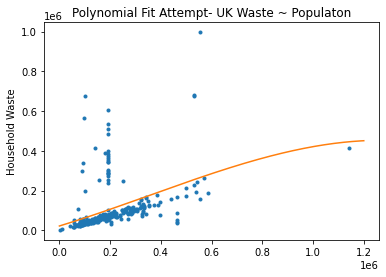

In [245]:
# Now use non-linear (polynomial) regression: for UK
xe = df_ctble['Population'].values
ye = df_ctble['Household - total waste (tonnes)'].values

# using order n polynomial 
f = np.polyfit(xe, ye, 3)
p = np.poly1d(f)
print(p)

#plot the chart

def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(0, 1200000, 314)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit Attempt- UK Waste ~ Populaton')
    plt.ylabel('Household Waste')

    plt.show()
    plt.close()

PlotPolly(p, xe, ye, 'Population')

In [246]:
#again a polynomial order does not seem to fit very nicely (despite checks from degree of 11 down to 3), 

            2
-4.226e-08 x + 0.3196 x + 3967


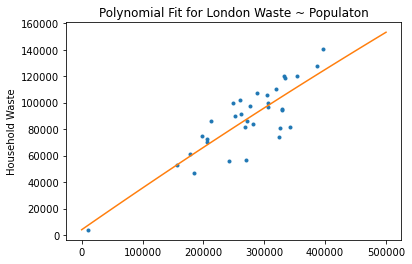

In [247]:
# Now use non-linear regression (polynomial) for London
xl = df_ctbll['Population'].values
yl = df_ctbll['Household - total waste (tonnes)'].values

# using order n polynomial 
fl = np.polyfit(xl, yl, 2)
pl = np.poly1d(fl)
print(pl)

#plot the chart

def PlotPollyl(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(0, 500000, 29)
    y_new = model(x_new)
    
    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit for London Waste ~ Populaton')
    plt.ylabel('Household Waste')
    
    plt.show()
    plt.close()
   
PlotPollyl(pl, xl, yl, 'Population')

In [248]:
# Split London data to train and test sets, fit a polynomial to the train data, test with test data
#checkin accuracy of models
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import r2_score

msk = np.random.rand(len(df_ctbll)) < 0.8
train = df_ctbll[msk]
test = df_ctbll[~msk]

train_x = np.asanyarray(train[['Population']])
train_y = np.asanyarray(train[['Household - total waste (tonnes)']])
test_x = np.asanyarray(test[['Population']])
test_y = np.asanyarray(test[['Household - total waste (tonnes)']])

poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)

In [249]:
#Obtain coefficients of the fitted model
clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[0.00000000e+00 2.89476698e-01 5.30940459e-08]]
Intercept:  [4823.99129591]


Mean absolute error: 16431.68
Residual sum of squares (MSE): 400491125.53
R2-score: -1.62


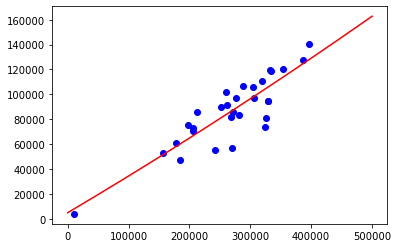

In [250]:
plt.scatter(train[['Population']], train[['Household - total waste (tonnes)']],  color='blue')
XX = np.arange(0, 500000, 29)
yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)
plt.plot(XX, yy, '-r' )

#check for accuracy based on error, measn squared errors and R^2 values
test_x_poly = poly.fit_transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_ , test_y) )

In [251]:
# Negative or zero r2 value still means the model may not be better than using a simple average for predictions

popt = 69282.8639, pcov = 0.0000


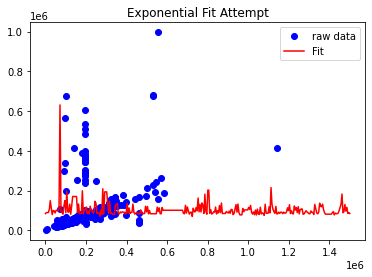

In [252]:
#Now we check exponential fit
import scipy
from scipy.optimize import curve_fit 

xe = df_ctble['Population'].values
ye = df_ctble['Household - total waste (tonnes)'].values

def efunc1(xe, a, b):
    return a*np.exp(b*xe)

popt, p_cov = curve_fit(efunc1, xe, ye, p0=(0,0))
print("popt = %.4f, pcov = %.4f" % (popt[0], popt[1]))

Y_pred = (popt[0]*(np.exp(popt[1]*xe)))
xx = np.linspace(0, 1500000, 314)

plt.plot(xe, ye, 'bo', label = 'raw data')
plt.plot(xx, Y_pred, 'r', label = 'Fit')
plt.title('Exponential Fit Attempt')
plt.legend(loc = 'best')

popt = 0.0695, pcov = 2.2090


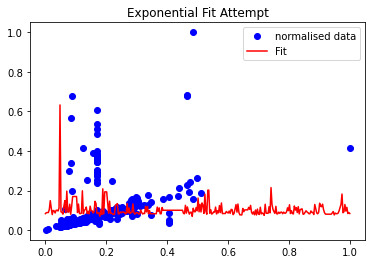

In [253]:
# Trying again with normalised x and y data
xe_norm = np.array(xe/max(xe))
ye_norm = np.array(ye/max(ye))

def efunc2(xe_norm, a, b):
    return a*np.exp(b*xe_norm)

popt, p_cov = curve_fit(efunc2, xe_norm, ye_norm, p0=(0, 0))
print("popt = %.4f, pcov = %.4f" % (popt[0], popt[1]))
Y_pred = (popt[0]*(np.exp(popt[1]*xe_norm)))
xx = np.linspace(0, 1, 314)

plt.plot(xe_norm, ye_norm, 'bo', label = 'normalised data')
plt.plot(xx, Y_pred, 'r', label = 'Fit')
plt.title('Exponential Fit Attempt')
plt.legend(loc = 'best')

popt = 284.3245, pcov = -0.0017


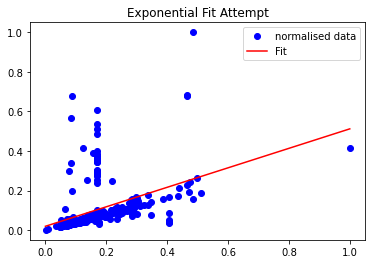

In [254]:
#another go using an extra constant term in the exponential function
def efunc3(xe_norm, a, b, c):
    return a*np.exp(-b*xe_norm) + c

popt, p_cov = curve_fit(efunc3, xe_norm, ye_norm, p0 = (1, 0, 1))
print("popt = %.4f, pcov = %.4f" % (popt[0], popt[1]))
xx = np.linspace(0, 1, 314)
Y_pred = efunc3(xx, *popt)

plt.plot(xe_norm, ye_norm, 'bo', label = 'normalised data')
plt.plot(xx, Y_pred, 'r', label = 'Fit')
plt.title('Exponential Fit Attempt')
plt.legend(loc = 'best')

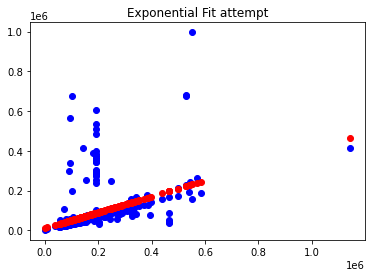

In [255]:
# testing an exponential fit again with an extra term/parameter (c1 - function of x) in  the expression
# and to see if the curve can be better tailored using other guess parameters

def exp44(xe, c0, c1, c2, c3):
    return c0 + c1*xe - c2*np.exp(-c3*xe)

g= [1e4, 0.4, -1e12, 0.01]

n = len(df_ctble['Population'])
ypred = np.empty(n)
for i in range(n):
    ypred[i] = exp44(xe[i], g[0], g[1], g[2], g[3])
    
plt.title('Exponential Fit attempt')
plt.plot(xe, ye, 'bo')
plt.plot(xe, ypred, 'ro')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[ 1.99563561e+04  4.29437873e-01 -5.16984238e+17  2.32506934e+02]
R^2: 0.18796280452255165


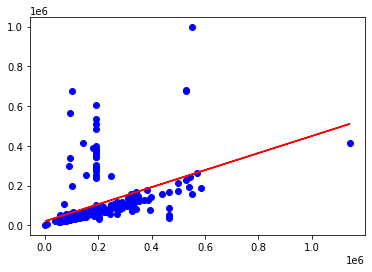

In [256]:
# refit the curve starting with the previous optimised guess to see if the fit and R^2 gets better
popt, pcov = curve_fit(exp44, xe, ye, g)
print(popt)

ypred = np.empty(n)

for i in range(n):
    ypred[i] = exp44(xe[i], popt[0], popt[1], popt[2], popt[3])
    
plt.plot(xe, ye, 'bo')
plt.plot(xe, ypred, 'r-')
print("R^2:", r2_score(ye, ypred))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[-2.66411604e+05  1.32844844e-02]


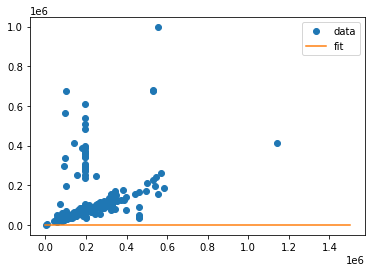

In [257]:
# Due to poor exponential fit, let's check logistic/sigmoidal fit
import pylab
xe = df_ctble['Population'].values
ye = df_ctble['Household - total waste (tonnes)'].values

def sigmoid1(xe, x0, k):
     y = 1 / (1 + np.exp(-k*(xe-x0)))
     return y

popt, pcov = curve_fit(sigmoid1, xe, ye, p0=(1, 0.00015))
print(popt)

xx = np.linspace(0, 1500000, 314)
Y_pred = sigmoid1(xx, *popt)

pylab.plot(xe, ye, 'o', label='data')
pylab.plot(xx,Y_pred, label='fit')
pylab.legend(loc='best')
pylab.show()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


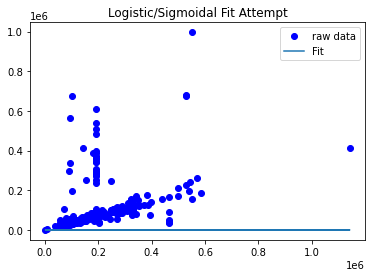

In [258]:
#trying out log and logistic regression using different guess parameters
xe = df_ctble['Population'].values
ye = df_ctble['Household - total waste (tonnes)'].values


def sigmoid2(xe, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(xe-Beta_2)))
     return y

beta_1 = 0.01
beta_2 = 100000

#logistic function
Y_pred = sigmoid2(xe, beta_1 , beta_2)

plt.title('Logistic/Sigmoidal Fit Attempt')
plt.plot(xe, ye, 'bo', label = 'raw data')
plt.plot(xe, Y_pred, label = 'Fit')
plt.legend(loc = 'best')

 beta_1 = 3.612093, beta_2 = 0.780829


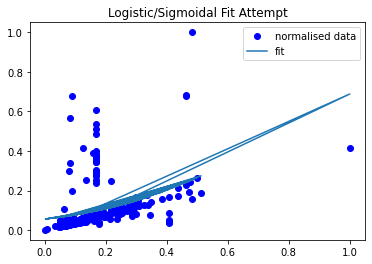

In [259]:
#Another go at sigmoidal fit using normalised data
xe_norm = np.array(xe/max(xe))
ye_norm = np.array(ye/max(ye))

def sigmoid3(xe_norm, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(xe_norm-Beta_2)))
     return y

popt, pcov = curve_fit(sigmoid3, xe_norm, ye_norm, p0=(1, 1))

#print the final parameters
print(" beta_1 = %f, beta_2 = %f" % (popt[0], popt[1]))

y = sigmoid3(xe_norm, *popt)
plt.title('Logistic/Sigmoidal Fit Attempt')
plt.plot(xe_norm, ye_norm, 'bo', label='normalised data')
plt.plot(xe_norm,y, label='fit')
plt.legend(loc = 'best')
plt.show()

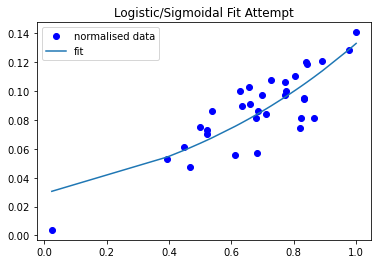

Mean absolute error: 0.0055
Residual sum of squares (MSE): 0.0001
R2 score: 0.8920


In [260]:
#Another go at sigmoidal using london data and splitting into train and test sets
# Splitting the dataset for London, training with 80% of the data with sigmoidal fit
# and testing the model with the remainder 20% of the data
# and finally checking accuracy based on erros, mean squared of errors and r2 values. 
msk = np.random.rand(len(df_ctbll)) <0.8

xl_norm = np.array(df_ctbll['Population']/max(df_ctbll['Population']))
yl_norm = np.array(df_ctbll['Household - total waste (tonnes)']/max(df_ctble['Household - total waste (tonnes)']))

train_xl = xl_norm[msk]
train_yl = yl_norm[msk]
test_xl = xl_norm[~msk]
test_yl = yl_norm[~msk]

def sigmoid3(xl_norm, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(xl_norm-Beta_2)))
     return y

popt, pcov = curve_fit(sigmoid3, train_xl, train_yl, p0=(1, 1))

y = sigmoid3(test_xl, *popt)
y2 = sigmoid3(xl_norm, *popt)

plt.title('Logistic/Sigmoidal Fit Attempt')
plt.plot(xl_norm, yl_norm, 'bo', label='normalised data')
plt.plot(xl_norm, y2, label='fit')
plt.legend(loc = 'best')
plt.show()

print('Mean absolute error: %.4f' % np.mean(np.absolute(y - test_yl)))
print("Residual sum of squares (MSE): %.4f" % np.mean((y - test_yl) ** 2))
print('R2 score: %.4f' % r2_score(y, test_yl))


In [261]:
#negative R2 value means the model is not as good as using a simple average for predictions

## Cluster Analysis of the Data of Waste & Population

In [262]:
Xm = df_ctble[['Population', 'Household - total waste (tonnes)']]
Xm.head()

Population  Household - total waste (tonnes)
0            97,761.00                         41,187.00
1           128,147.00                         45,826.00
2           127,918.00                         45,939.00
3           130,032.00                         41,729.00
4           212,906.00                         86,072.00

In [263]:
xm = np.array(Xm)
k_means = KMeans(init = "k-means++", n_clusters = 5, n_init = 12)
k_means.fit(xm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [264]:
#obtain cluster label for each data row
k_means_labels = k_means.labels_
k_means_labels

array([1, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 3, 1, 1, 3, 4, 1, 1, 1, 3, 2, 1,
       2, 1, 1, 3, 1, 3, 2, 2, 2, 2, 2, 1, 3, 1, 1, 1, 2, 1, 1, 3, 3, 1,
       1, 1, 3, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 4, 4, 2, 3, 1,
       2, 1, 1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 1, 3, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1,
       1, 3, 1, 2, 1, 3, 1, 3, 3, 1, 2, 1, 1, 2, 4, 1, 3, 1, 1, 1, 1, 3,
       1, 1, 1, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1,
       3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1,
       1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 2, 3, 3, 0, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [265]:
#obtain cluster centre coordinates for each of the 5 clusters
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[173869.30769231, 379045.73076923],
       [117065.29842932,  44598.7539267 ],
       [479885.11111111, 150823.11111111],
       [274116.2       , 102354.34666667],
       [688715.5       , 691465.75      ]])

Text(0.5, 0, 'Population')

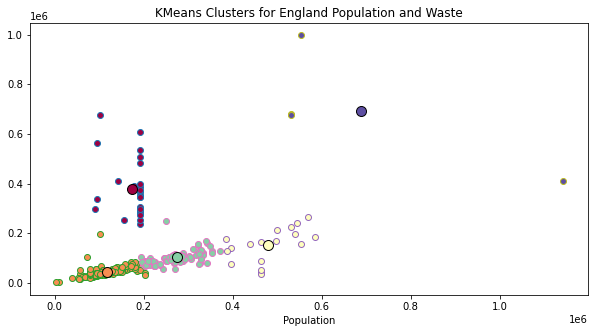

In [266]:
# create plot
fig = plt.figure(figsize=(10, 5))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))
ax = fig.add_subplot(1, 1, 1)

#loop for data points and their centroids
for k, col in zip(range(len(k_means_cluster_centers)), colors):
    my_members = (k_means_labels == k) #only members in each group are True, others are false
    cluster_center = k_means_cluster_centers[k]
    
    ax.plot(xm[my_members, 0], xm[my_members, 1], 'o', markerfacecolor=col, marker='o') # for datapoints and their colours
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=10) #for centroids

ax.set_title('KMeans Clusters for England Population and Waste')
ax.set_xlabel('Population')

In [280]:
'''
The k-means cluster analysis generated the chart and categories of LAs below for the England dataset. 
There seems to be 3 main clusters with low waste levels and they are mainly low population:
Low Population LAs (<200k people) with Low Waste (<200k tonnes/year) - (LP LW) – Orange. 
Low Population LAs (<400k people) with Low Waste (<200k tonnes/year) - (LP LW) – Green. 
Medium Population LAs (>400k people) with Low Waste (<300k tonnes/year) - (MP - LW) – Yellow.

Also, there are two clusters with medium to high waste levels: 
Low Population LAs (<200k people) with Medium Waste (>200k tonnes/year) - (LP MW) – Wine.
High Population LAs (>500k people) with High Waste (>400k tonnes/year) - (HP LW) – Purple.
'''


'\nThe k-means cluster analysis generated the chart and categories of LAs below for the England dataset. \nThere seems to be 3 main clusters with low waste levels and they are mainly low population:\nLow Population LAs (<200k people) with Low Waste (<200k tonnes/year) - (LP LW) – Orange. \nLow Population LAs (<400k people) with Low Waste (<200k tonnes/year) - (LP LW) – Green. \nMedium Population LAs (>400k people) with Low Waste (<300k tonnes/year) - (MP - LW) – Yellow.\n\nAlso, there are two clusters with medium to high waste levels: \nLow Population LAs (<200k people) with Medium Waste (>200k tonnes/year) - (LP MW) – Wine.\nHigh Population LAs (>500k people) with High Waste (>400k tonnes/year) - (HP LW) – Purple.\n'

In [268]:
#Repeating Kmeans clusters for London only
Xml = df_ctbll[['Population', 'Household - total waste (tonnes)']]
Xml.head()

Population  Household - total waste (tonnes)
0           395,869.00                        140,316.00
1           386,710.00                        127,946.00
2           353,134.00                        120,309.00
3           341,806.00                         81,369.00
4           333,794.00                        118,449.00

In [269]:
xml = np.array(Xml)
kl_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)
kl_means.fit(xml)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [270]:
#obtain cluster label for each data row
kl_means_labels = kl_means.labels_
kl_means_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3], dtype=int32)

In [271]:
#obtain cluster centre coordinates for each of the 5 clusters
kl_means_cluster_centers = kl_means.cluster_centers_
kl_means_cluster_centers

array([[335045.71428571, 104678.57142857],
       [191800.14285714,  66449.28571429],
       [265366.09090909,  86373.45454545],
       [  9721.        ,   3818.        ]])

Text(0.5, 0, 'Population')

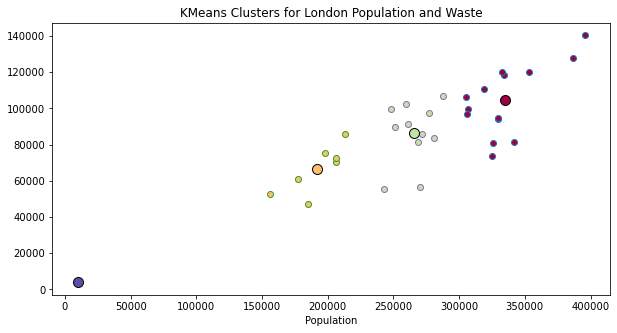

In [272]:
# create plot
fig = plt.figure(figsize=(10, 5))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(kl_means_labels))))
ax = fig.add_subplot(1, 1, 1)

#loop for data points and their centroids
for k, col in zip(range(len(kl_means_cluster_centers)), colors):
    my_membersl = (kl_means_labels == k) #only members in each group are True, others are false
    cluster_centerl = kl_means_cluster_centers[k]
    
    ax.plot(xml[my_membersl, 0], xml[my_membersl, 1], 'o', markerfacecolor=col, marker='o') # for datapoints and their colours
    ax.plot(cluster_centerl[0], cluster_centerl[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=10) #for centroids

ax.set_title('KMeans Clusters for London Population and Waste')
ax.set_xlabel('Population')

In [281]:
'''
Of the four London Clusters, there is one outlier/lone LA with very low population and waste (Purple). 
This is the City of London which has extremely low number of households, 
as it is a mostly financial and banking LA, which explains the low waste levels. 
At a national context, all London LAs are Low population and low waste category above, 
but with a particular focus and scale within London, there seems to be 3 main clusters with medium to high waste levels:
Medium Population (<250k people) with Medium Waste (<100k tonnes/year) - (MP MW) – Orange.
Medium Population LAs (<300k people) with High Waste (<120k tonnes/year) - (MP HW) – Green.
High Population LAs (>300k people) with Medium to High Waste (80k – 140k tonnes/year) – (HP HW) – Wine.
'''

'\nOf the four London Clusters, there is one outlier/lone LA with very low population and waste (Purple). \nThis is the City of London which has extremely low number of households, \nas it is a mostly financial and banking LA, which explains the low waste levels. \nAt a national context, all London LAs are Low population and low waste category above, \nbut with a particular focus and scale within London, there seems to be 3 main clusters with medium to high waste levels:\nMedium Population (<250k people) with Medium Waste (<100k tonnes/year) - (MP MW) – Orange.\nMedium Population LAs (<300k people) with High Waste (<120k tonnes/year) - (MP HW) – Green.\nHigh Population LAs (>300k people) with Medium to High Waste (80k – 140k tonnes/year) – (HP HW) – Wine.\n'

### Attempts at Foilum chorolpleth

In [274]:
#using world country boundaries for testing.
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/world_countries.json -O world_countries.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [275]:
world_geo = r'world_countries.json'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total POPULATION

threshold_scale = np.linspace(df_ctbll['Population'].min(), df_ctbll['Population'].max(), 6, dtype=int)

threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.
londonf_map = folium.Map(location=[latitudeld, longitudeld], zoom_start=6, tiles='Mapbox Bright')
londonf_map.choropleth(
    geo_data=world_geo,
    data=df_ctbll,
    columns=['Local Authorityl', 'Population'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='London Population in 2019',
    reset=True
)
londonf_map

In [276]:
#The above attempt used World geojson which had no England Local Authorities boundary information

In [277]:
!wget --quiet https://martinjc.github.io/UK-GeoJSON/json/eng/topo_lad.json -O UK_counties.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [278]:
#using UK geojason with Local Authority Boundaries
uk_geo = r'UK_counties.json'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total POPULATION

threshold_scale = np.linspace(df_ctble['Population'].min(), df_ctble['Population'].max(), 6, dtype=int)

threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.
londonf_map = folium.Map(location=[latitudeld, longitudeld], zoom_start=4, tiles='Mapbox Bright')
londonf_map.choropleth(
    geo_data=uk_geo,
    data=df_ctble,
    columns=['Local Authorityp', 'Population'],
    key_on= 'properties.lad13nm',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='UK Population in 2019',
    reset=True
)
londonf_map

In [279]:
# It appears the key_on parameters used is ill-defined, so the the above UK Local Authorities geojson does not render accurately
# This would have been useful to display waste and population distribution across England and London Local Authorities